# AIFFEL Hackerthon 1 - Visitor prediction

[colab](https://colab.research.google.com/drive/1smPns4wZvFKdrd9qsm7YYqI7nasYJn73?usp=sharing)

## 0. Kaggle에서 데이터 다운로드 받기

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

In [ ]:
ls -1ha kaggle.json

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

In [ ]:
!kaggle competitions download -c recruit-restaurant-visitor-forecasting

## 1. 모듈 임포트, 데이터 준비하기

In [373]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [374]:
air_reserve = pd.read_csv("air_reserve.csv.zip")
hpg_reserve = pd.read_csv("hpg_reserve.csv.zip")
air_store_info = pd.read_csv("air_store_info.csv.zip")
hpg_store_info = pd.read_csv("hpg_store_info.csv.zip")
air_visit_data = pd.read_csv("air_visit_data.csv.zip")  
store_id_relation = pd.read_csv("store_id_relation.csv.zip")
date_info = pd.read_csv("date_info.csv.zip")
sample_submission = pd.read_csv("sample_submission.csv.zip")

In [375]:
### 원본 저장하기 ###
air_reserve_orig = air_reserve.copy()
hpg_reserve_orig = hpg_reserve.copy()
air_store_info_orig = air_store_info.copy()
hpg_store_info_orig = hpg_store_info.copy()
air_visit_data_orig = air_visit_data.copy() ## EDA
store_id_relation_orig = store_id_relation.copy() ## mapping -> merge
date_info_orig = date_info.copy() ## holiday => reserve
sample_submission_orig = sample_submission.copy()

## 2. EDA

`air_reserve` 부터 `date_info`까지 하나씩 EDA를 해보겠습니다. (`sample_submission`의 경우 제출용 파일임으로 생략하겠습니다.)

### 2-1. Analysis of `air_reserve`
주의할 것은 `air_reserve`는 예약을 하고 방문한 사람의 데이터만 가지고 있습니다. 따라서 `air_visit_data`를 고려해보면, 같은 매장에 예약을 하지않고 방문하는 인원도 있을 수 있고, 또 예약을 애초에 받지 않는 매장도 있을 수 있습니다. 그리고 예약을 하고 온 인원도 포함되있을 것 같습니다. 이 내용은 아래에 별도로 정리를 해두었습니다.

따라서 `air_reserve` 데이터는 __예약한 인원 수__에 대한 데이터로 보는 것이 좋습니다. 실제 방문객에 대한 데이터로 사용하기는 어려울 수 있다는 의미입니다.

_reserve_visitors - the number of visitors for that reservation_

In [376]:
air_reserve.head()

air_store_id  ... reserve_visitors
0  air_877f79706adbfb06  ...                1
1  air_db4b38ebe7a7ceff  ...                3
2  air_db4b38ebe7a7ceff  ...                6
3  air_877f79706adbfb06  ...                2
4  air_db80363d35f10926  ...                5

[5 rows x 4 columns]

In [377]:
air_reserve.describe()

reserve_visitors
count      92378.000000
mean           4.481749
std            4.919669
min            1.000000
25%            2.000000
50%            3.000000
75%            5.000000
max          100.000000

In [378]:
air_reserve.isnull().sum()

air_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [379]:
air_reserve.dtypes

air_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

예약시간, 방문시간과 방문객 사이의 관계를 한번 알아보겠습니다.

우선 visit_datetime과 reserve_datetime에 해당하는 컬럼의 자료형을 object에서 datetime 으로 바꿔주겠습니다.

In [380]:
air_reserve['visit_datetime'] = pd.to_datetime(air_reserve['visit_datetime'])
air_reserve['reserve_datetime'] = pd.to_datetime(air_reserve['reserve_datetime'])

그래프를 그리기 위해 날짜별로 인원수 합을 구해보겠습니다.

In [381]:
visit_time_visitors = pd.pivot_table(air_reserve, index='visit_datetime', values='reserve_visitors', aggfunc='sum').reset_index()
reserve_time_visitors = pd.pivot_table(air_reserve, index='reserve_datetime', values='reserve_visitors', aggfunc='sum').reset_index()

print(f"visit_time_visitors has {len(visit_time_visitors)} rows.")
print(f"reserve_time_visitors has {len(reserve_time_visitors)} rows.")

display(visit_time_visitors.head())
display(reserve_time_visitors.head())

visit_time_visitors has 4975 rows.
reserve_time_visitors has 7513 rows.


visit_datetime  reserve_visitors
0 2016-01-01 19:00:00                10
1 2016-01-01 20:00:00                 7
2 2016-01-02 01:00:00                 6
3 2016-01-02 16:00:00                 4
4 2016-01-02 17:00:00                77

reserve_datetime  reserve_visitors
0 2016-01-01 01:00:00                 5
1 2016-01-01 02:00:00                 2
2 2016-01-01 12:00:00                 6
3 2016-01-01 14:00:00                 6
4 2016-01-01 15:00:00                 4

그래프를 그리려고 보니 각각 4975, 7513개의 그래프를 모두 막대그래프로 표현하는데는 무리가 있을 것 같습니다. 우선 25개 정도의 row를 대상으로 그래프를 그려보겠습니다.

[Text(0, 0, '2016-01-01T19:00:00'),
 Text(0, 0, '2016-01-01T20:00:00'),
 Text(0, 0, '2016-01-02T01:00:00'),
 Text(0, 0, '2016-01-02T16:00:00'),
 Text(0, 0, '2016-01-02T17:00:00'),
 Text(0, 0, '2016-01-02T18:00:00'),
 Text(0, 0, '2016-01-02T19:00:00'),
 Text(0, 0, '2016-01-02T21:00:00'),
 Text(0, 0, '2016-01-03T00:00:00'),
 Text(0, 0, '2016-01-03T12:00:00'),
 Text(0, 0, '2016-01-03T13:00:00'),
 Text(0, 0, '2016-01-03T14:00:00'),
 Text(0, 0, '2016-01-03T18:00:00'),
 Text(0, 0, '2016-01-03T19:00:00'),
 Text(0, 0, '2016-01-03T21:00:00'),
 Text(0, 0, '2016-01-03T22:00:00'),
 Text(0, 0, '2016-01-04T15:00:00'),
 Text(0, 0, '2016-01-04T16:00:00'),
 Text(0, 0, '2016-01-04T17:00:00'),
 Text(0, 0, '2016-01-04T18:00:00'),
 Text(0, 0, '2016-01-04T19:00:00'),
 Text(0, 0, '2016-01-04T20:00:00'),
 Text(0, 0, '2016-01-04T21:00:00'),
 Text(0, 0, '2016-01-04T22:00:00'),
 Text(0, 0, '2016-01-04T23:00:00')]

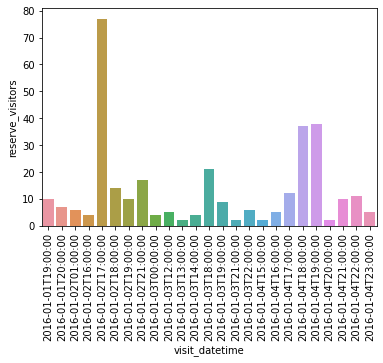

In [382]:
import matplotlib.dates as mdates
fig, ax = plt.subplots()
sns.barplot(x=visit_time_visitors["visit_datetime"].iloc[0:25], y=visit_time_visitors["reserve_visitors"].iloc[0:25], ax=ax)
x_tick_labels = [t.get_text()[:19] for t in ax.get_xticklabels()]
ax.set_xticklabels(x_tick_labels, rotation=90)


위와 같은 결과가 나옵니다. 2016년 1월 2일 17시가 가장 예약객이 많은 시간인 건 알 수 있지만, 그다지 유믜미한 정보를 찾을 수 있는 시각화는 아닙니다. 따라서 다음의 세부적인 경우로 나누어 데이터를 살펴보겠습니다.

#### 예약객 정보


1. 요일별 예약객 정보: 주말이나 공휴일
2. 월별 예약객 정보: 계절이랑 비슷할 것
3. 계절별 예약객 정보: 제철음식, 음식장르와 관련이 있을 것 같음
4. 시간대별: 저녁시간, 점심시간, ...

##### 1. 요일별 예약객 정보

In [383]:
visit_datetime_day = air_reserve['visit_datetime'].dt.day_name()
reserve_datetime_day = air_reserve['reserve_datetime'].dt.day_name()

In [384]:
air_reserve['visit_datetime_day'] = visit_datetime_day
air_reserve['reserve_datetime_day'] = reserve_datetime_day

In [385]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visit_day_visitors = pd.pivot_table(air_reserve, index='visit_datetime_day', values='reserve_visitors', aggfunc='sum').reindex(days).reset_index()
reserve_day_visitors = pd.pivot_table(air_reserve, index='reserve_datetime_day', values='reserve_visitors', aggfunc='sum').reindex(days).reset_index()

print(f"visit_day_visitors has {len(visit_day_visitors)} rows.")
print(f"reserve_day_visitors has {len(reserve_day_visitors)} rows.")


display(visit_day_visitors)
display(reserve_day_visitors)

visit_day_visitors has 7 rows.
reserve_day_visitors has 7 rows.


visit_datetime_day  reserve_visitors
0             Monday             36065
1            Tuesday             42938
2          Wednesday             52341
3           Thursday             54538
4             Friday             92565
5           Saturday             91943
6             Sunday             43625

reserve_datetime_day  reserve_visitors
0               Monday             57381
1              Tuesday             69197
2            Wednesday             68277
3             Thursday             68929
4               Friday             64025
5             Saturday             49263
6               Sunday             36943

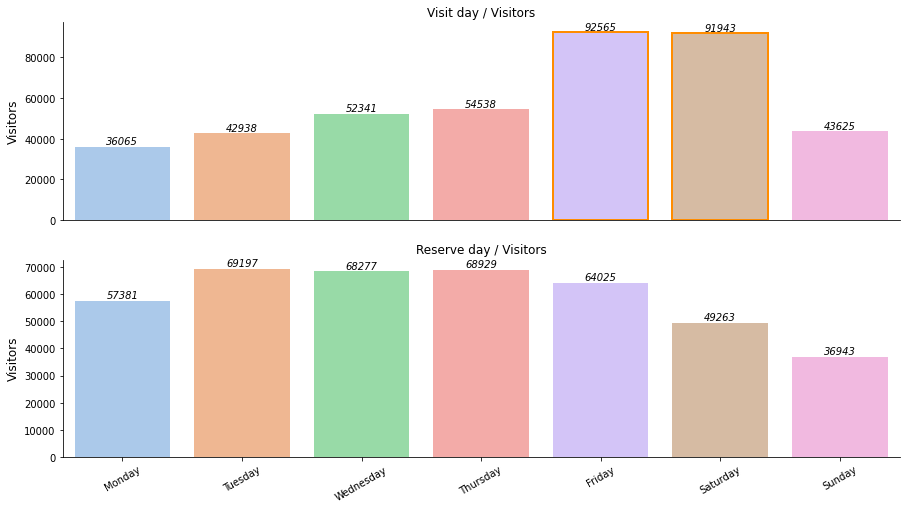

In [386]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_day_visitors, x="visit_datetime_day", y="reserve_visitors", ax=axs[0], palette=colors)

axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit day / Visitors")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+1000), ha = 'center', color = 'k', style='italic')

axs[0].patches[4].set_linewidth('2')
axs[0].patches[4].set_edgecolor('darkorange')
axs[0].patches[5].set_linewidth('2')
axs[0].patches[5].set_edgecolor('darkorange')

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.barplot(data=reserve_day_visitors, x="reserve_datetime_day", y="reserve_visitors", ax=axs[1], palette=colors)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve day / Visitors")
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+1000), ha = 'center', color = 'k', style='italic')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

위에서 볼 수 있듯이 예약하는 날짜와 방문객은 별로 상관이 없어 보입니다. 반면에 방문하는 날짜는 일반적으로 금요일, 토요일에 많이 올려있는 모습을 볼 수 있습니다.

##### 2. 월별 예약객 정보

In [387]:
visit_datetime_month = air_reserve['visit_datetime'].dt.month_name()
reserve_datetime_month = air_reserve['reserve_datetime'].dt.month_name()
air_reserve['visit_datetime_month'] = visit_datetime_month
air_reserve['reserve_datetime_month'] = reserve_datetime_month

In [388]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
visit_month_visitors = pd.pivot_table(air_reserve, index='visit_datetime_month', values='reserve_visitors', aggfunc='sum').reindex(months).reset_index()
reserve_month_visitors = pd.pivot_table(air_reserve, index='reserve_datetime_month', values='reserve_visitors', aggfunc='sum').reindex(months).reset_index()

print(f"visit_month_visitors has {len(visit_month_visitors)} rows.")
print(f"reserve_month_visitors has {len(reserve_month_visitors)} rows.")


display(visit_month_visitors)
display(reserve_month_visitors)

visit_month_visitors has 12 rows.
reserve_month_visitors has 12 rows.


visit_datetime_month  reserve_visitors
0               January             58824
1              February             61807
2                 March             79191
3                 April             58217
4                   May             13432
5                  June              4590
6                  July              4603
7                August                 2
8             September                12
9               October              7854
10             November             46619
11             December             78864

reserve_datetime_month  reserve_visitors
0                 January             62393
1                February             61788
2                   March             75774
3                   April             51990
4                     May              8582
5                    June              6010
6                    July              3779
7                  August              1077
8               September              2412
9                 October             20122
10               November             60408
11               December             59680

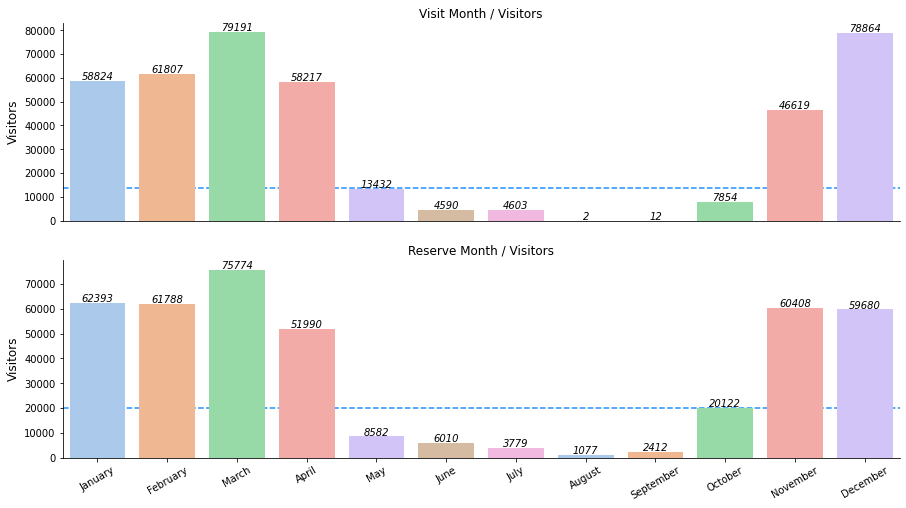

In [389]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_month_visitors, x="visit_datetime_month", y="reserve_visitors", ax=axs[0], palette=colors, zorder=2)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Month / Visitors")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[0].axhline(y = 13500, color = 'dodgerblue', ls = '--', zorder = 1)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.barplot(data=reserve_month_visitors, x="reserve_datetime_month", y="reserve_visitors", ax=axs[1], palette=colors, zorder=2)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Month / Visitors")
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[1].axhline(y = 20200, color = 'dodgerblue', ls = '--', zorder = 1)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

월별 예약객/방문객을 구별해보면 유달리 5월부터 9월 사이에 상당히 적은 인원이 예약/방문을 하고 있으며 10월에도 비교적 적은 수를 보이고 있습니다. 무슨 이유가 있는 지 확실히 알 수는 없지만 air 서비스를 사용할 수 없었다거나 무슨 이유가 있을 것 같습니다.

##### 3. 계절별 예약 방문객 정보

`np.where`을 사용해 계절을 표현하는 컬럼을 만들어줍니다.

In [390]:
air_reserve['visit_datetime_season'] = ""
air_reserve['reserve_datetime_season'] = ""

In [391]:
air_reserve['visit_datetime_season'] = np.where(air_reserve['visit_datetime_month'].isin(["March", "April", "May"]), 'Spring', air_reserve['visit_datetime_season'])
air_reserve['visit_datetime_season'] = np.where(air_reserve['visit_datetime_month'].isin(["June", "July", "August"]), 'Summer', air_reserve['visit_datetime_season'])
air_reserve['visit_datetime_season'] = np.where(air_reserve['visit_datetime_month'].isin(["September", "October", "November"]), 'Fall', air_reserve['visit_datetime_season'])
air_reserve['visit_datetime_season'] = np.where(air_reserve['visit_datetime_month'].isin(["December", "January", "February"]), 'Winter', air_reserve['visit_datetime_season'])

In [392]:
air_reserve['reserve_datetime_season'] = np.where(air_reserve['reserve_datetime_month'].isin(["March", "April", "May"]), 'Spring', air_reserve['reserve_datetime_season'])
air_reserve['reserve_datetime_season'] = np.where(air_reserve['reserve_datetime_month'].isin(["June", "July", "August"]), 'Summer', air_reserve['reserve_datetime_season'])
air_reserve['reserve_datetime_season'] = np.where(air_reserve['reserve_datetime_month'].isin(["September", "October", "November"]), 'Fall', air_reserve['reserve_datetime_season'])
air_reserve['reserve_datetime_season'] = np.where(air_reserve['reserve_datetime_month'].isin(["December", "January", "February"]), 'Winter', air_reserve['reserve_datetime_season'])

In [393]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
visit_season_visitors = pd.pivot_table(air_reserve, index='visit_datetime_season', values='reserve_visitors', aggfunc='sum').reindex(seasons).reset_index()
reserve_season_visitors = pd.pivot_table(air_reserve, index='reserve_datetime_season', values='reserve_visitors', aggfunc='sum').reindex(seasons).reset_index()

print(f"visit_season_visitors has {len(visit_season_visitors)} rows.")
print(f"reserve_season_visitors has {len(reserve_season_visitors)} rows.")


display(visit_season_visitors)
display(reserve_season_visitors)

visit_season_visitors has 4 rows.
reserve_season_visitors has 4 rows.


visit_datetime_season  reserve_visitors
0                Spring            150840
1                Summer              9195
2                  Fall             54485
3                Winter            199495

reserve_datetime_season  reserve_visitors
0                  Spring            136346
1                  Summer             10866
2                    Fall             82942
3                  Winter            183861

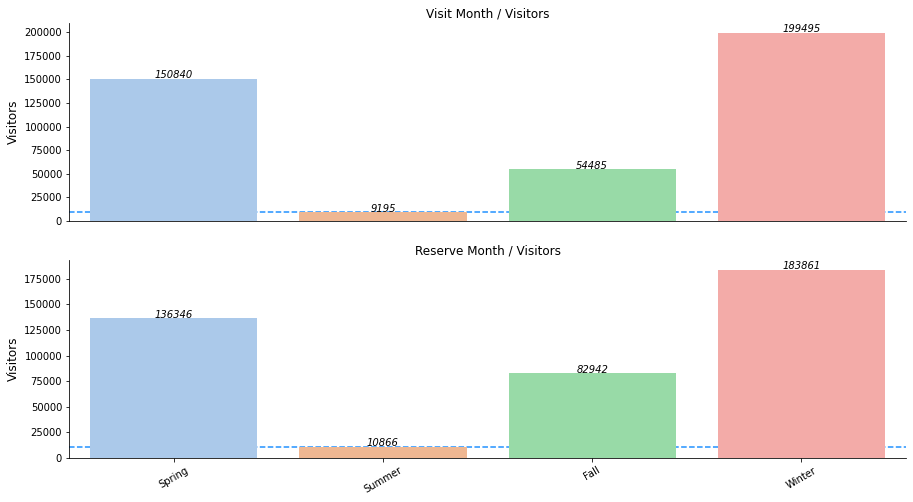

In [394]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_season_visitors, x="visit_datetime_season", y="reserve_visitors", ax=axs[0], palette=colors, zorder=2)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Month / Visitors")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[0].axhline(y = 9200, color = 'dodgerblue', ls = '--', zorder = 1)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.barplot(data=reserve_season_visitors, x="reserve_datetime_season", y="reserve_visitors", ax=axs[1], palette=colors, zorder=2)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Month / Visitors")
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[1].axhline(y = 11000, color = 'dodgerblue', ls = '--', zorder = 1)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

월별 정보와 비슷한 모습을 보입니다. 전체적으로 합쳐져서 여름에는 다른 계절에 비해 확연히 예약건수도 줄어들고 예약할 때 방문객 수도 현저히 적습니다.

##### 4. 시간대별 예약 방문객 정보

다른 데이터보다 가장 유의미할 것으로 생각이 듭니다. 왜냐하면 예약방문객, 심지어 예약할 떄 방문할 인원에 대한 정보이기 때문에 실제로 방문을 한 사람이 아니기 때문에 상황에 따라 크게 의미가 없는 데이터로 볼 수 있습니다.

따라서 언제 예약을 하는 지에 대한 정보가 더욱 유의미 할 수 있습니다.
예약할 때의 인원수보다 예약 건수 자체로 세는 것이 더욱 의미있을 수 있습니다.

In [395]:
air_reserve["reserve_datetime_hour"] = air_reserve["reserve_datetime"].dt.hour
air_reserve["visit_datetime_hour"] = air_reserve["visit_datetime"].dt.hour

In [396]:
visit_hour_visitors = pd.pivot_table(air_reserve, index='visit_datetime_hour', values='reserve_visitors', aggfunc='sum').reset_index()
reserve_hour_visitors = pd.pivot_table(air_reserve, index='reserve_datetime_hour', values='reserve_visitors', aggfunc='sum').reset_index()

print(f"visit_hour_visitors has {len(visit_hour_visitors)} rows.")
print(f"reserve_hour_visitors has {len(reserve_hour_visitors)} rows.")


display(visit_hour_visitors)
display(reserve_hour_visitors)

visit_hour_visitors has 24 rows.
reserve_hour_visitors has 24 rows.


visit_datetime_hour  reserve_visitors
0                     0              2758
1                     1              2190
2                     2              1218
3                     3               707
4                     4               414
5                     5               142
6                     6                38
7                     7                87
8                     8                60
9                     9                92
10                   10               941
11                   11              9674
12                   12              9021
13                   13              5460
14                   14              3094
15                   15              2096
16                   16              6556
17                   17             45600
18                   18            110467
19                   19             96437
20                   20             58929
21                   21             35414
22                   22             16555
23                   23              6065

reserve_datetime_hour  reserve_visitors
0                       0              8748
1                       1              4238
2                       2              1746
3                       3               999
4                       4               459
5                       5               438
6                       6               597
7                       7              1381
8                       8              2792
9                       9              3480
10                     10              6852
11                     11             14105
12                     12             16578
13                     13             17126
14                     14             17756
15                     15             22013
16                     16             29832
17                     17             58062
18                     18             57264
19                     19             38890
20                     20             33447
21                     21             30937
22                     22             27512
23                     23             18763

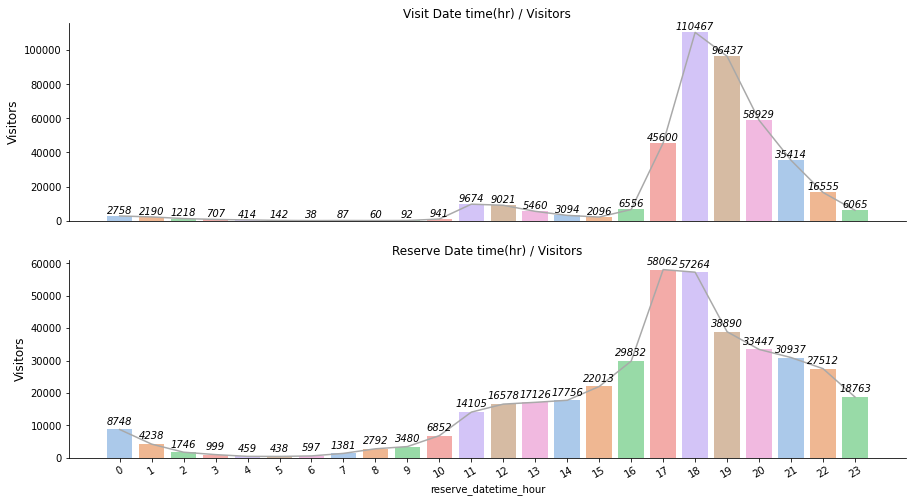

In [397]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_hour_visitors, x="visit_datetime_hour", y="reserve_visitors", ax=axs[0], palette=colors, zorder=1)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Date time(hr) / Visitors")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+1500), ha = 'center', color = 'k', style='italic')

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.lineplot(data=visit_hour_visitors, x="visit_datetime_hour", y="reserve_visitors", ax=axs[0], color='darkgrey', zorder=2)



sns.barplot(data=reserve_hour_visitors, x="reserve_datetime_hour", y="reserve_visitors", ax=axs[1], palette=colors, zorder=1)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Date time(hr) / Visitors")

sns.lineplot(data=reserve_hour_visitors, x="reserve_datetime_hour", y="reserve_visitors", ax=axs[1], color='darkgrey', zorder=2)

for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+1500), ha = 'center', color = 'k', style='italic')


axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

보통 예약할 때의 시간(`reserve_datetime`)은 17, 18시에 몰려있고 예약할 때의 방문시간(`visit_datetime`)은 18, 19시에 몰려있는 경향이 있습니다.

지금까지 데이터를 살펴보니 방문예정객수(`reserve_visitors`)를 살펴보기 보다는 예약 건수로 살펴보는 것이 더욱 의미가 있을 것 같습니다.

요일별, 월별, 계절, 시간대별로 예약 수 분석을 해보겠습니다.

#### 예약수 정보


1. 요일별 예약객 정보: 주말이나 공휴일
2. 월별 예약객 정보: 계절이랑 비슷할 것
3. 계절별 예약객 정보: 제철음식, 음식장르와 관련이 있을 것 같음
4. 시간대별: 저녁시간, 점심시간, ...

In [398]:
air_reserve["reserve_count"] = 1
total_reserve = pd.pivot_table(air_reserve, index='visit_datetime', values='reserve_count', aggfunc='sum').reset_index()
total_reserve.head(10)

visit_datetime  reserve_count
0 2016-01-01 19:00:00              3
1 2016-01-01 20:00:00              2
2 2016-01-02 01:00:00              2
3 2016-01-02 16:00:00              2
4 2016-01-02 17:00:00              8
5 2016-01-02 18:00:00              6
6 2016-01-02 19:00:00              3
7 2016-01-02 21:00:00              4
8 2016-01-03 00:00:00              1
9 2016-01-03 12:00:00              1

##### 1. 요일별 예약 수 정보

In [399]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visit_day_reserve_count = pd.pivot_table(air_reserve, index='visit_datetime_day', values='reserve_count', aggfunc='sum').reindex(days).reset_index()
reserve_day_reserve_count = pd.pivot_table(air_reserve, index='reserve_datetime_day', values='reserve_count', aggfunc='sum').reindex(days).reset_index()

print(f"visit_day_reserve_count has {len(visit_day_reserve_count)} rows.")
print(f"reserve_day_reserve_count has {len(reserve_day_reserve_count)} rows.")


display(visit_day_reserve_count)
display(reserve_day_reserve_count)

visit_day_reserve_count has 7 rows.
reserve_day_reserve_count has 7 rows.


visit_datetime_day  reserve_count
0             Monday           7883
1            Tuesday           9678
2          Wednesday          11395
3           Thursday          11991
4             Friday          19594
5           Saturday          21304
6             Sunday          10533

reserve_datetime_day  reserve_count
0               Monday          12057
1              Tuesday          14437
2            Wednesday          14733
3             Thursday          15227
4               Friday          14581
5             Saturday          12384
6               Sunday           8959

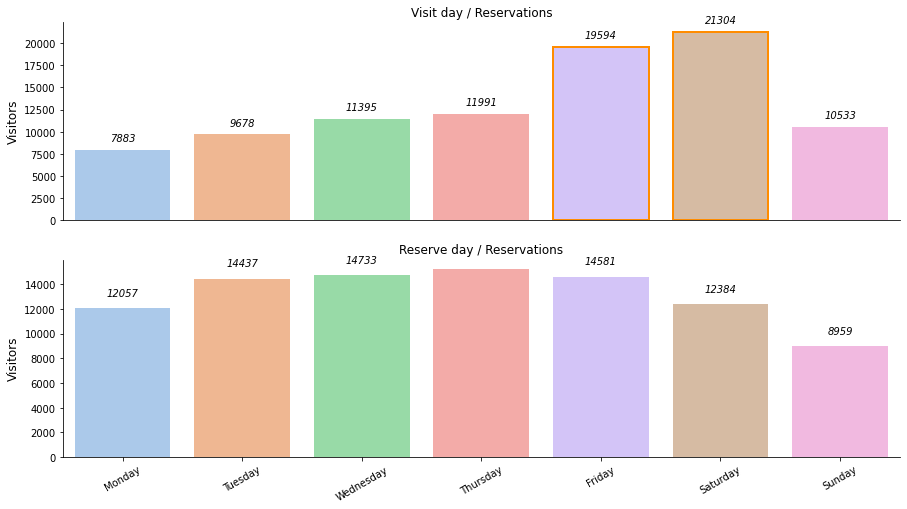

In [400]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_day_reserve_count, x="visit_datetime_day", y="reserve_count", ax=axs[0], palette=colors)

axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit day / Reservations") # 해당요일에 방문하겠다고 한 예약수 
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+1000), ha = 'center', color = 'k', style='italic')

axs[0].patches[4].set_linewidth('2')
axs[0].patches[4].set_edgecolor('darkorange')
axs[0].patches[5].set_linewidth('2')
axs[0].patches[5].set_edgecolor('darkorange')

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.barplot(data=reserve_day_reserve_count, x="reserve_datetime_day", y="reserve_count", ax=axs[1], palette=colors)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve day / Reservations") # 예약이 온 요일
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+1000), ha = 'center', color = 'k', style='italic')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

##### 월별 예약 수 정보



In [401]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
visit_month_reserve_count = pd.pivot_table(air_reserve, index='visit_datetime_month', values='reserve_count', aggfunc='sum').reindex(months).reset_index()
reserve_month_reserve_count = pd.pivot_table(air_reserve, index='reserve_datetime_month', values='reserve_count', aggfunc='sum').reindex(months).reset_index()

print(f"visit_month_reserve_count has {len(visit_month_reserve_count)} rows.")
print(f"reserve_month_reserve_count has {len(reserve_month_reserve_count)} rows.")


display(visit_month_reserve_count)
display(reserve_month_reserve_count)

visit_month_reserve_count has 12 rows.
reserve_month_reserve_count has 12 rows.


visit_datetime_month  reserve_count
0               January          13338
1              February          14959
2                 March          17296
3                 April          12817
4                   May           2754
5                  June           1003
6                  July           1085
7                August              1
8             September              5
9               October           1841
10             November          10936
11             December          16343

reserve_datetime_month  reserve_count
0                 January          14222
1                February          14504
2                   March          17111
3                   April          11861
4                     May           2027
5                    June           1198
6                    July            950
7                  August            139
8               September            227
9                 October           3481
10               November          12383
11               December          14275

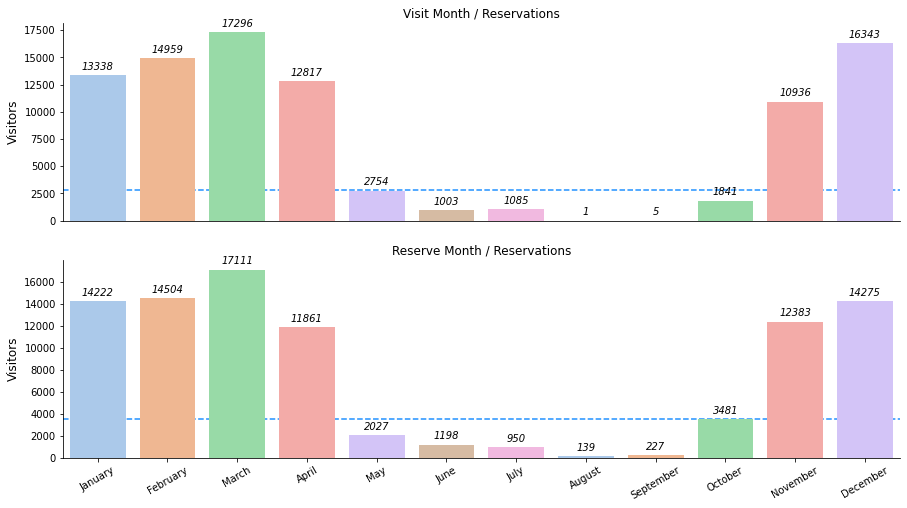

In [402]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_month_reserve_count, x="visit_datetime_month", y="reserve_count", ax=axs[0], palette=colors, zorder=2)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Month / Reservations")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[0].axhline(y = 2800, color = 'dodgerblue', ls = '--', zorder = 1)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.barplot(data=reserve_month_reserve_count, x="reserve_datetime_month", y="reserve_count", ax=axs[1], palette=colors, zorder=2)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Month / Reservations")
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[1].axhline(y = 3500, color = 'dodgerblue', ls = '--', zorder = 1)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

##### 3. 계절별 예약 수 정보

In [403]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
visit_season_visitors_reserve_count = pd.pivot_table(air_reserve, index='visit_datetime_season', values='reserve_count', aggfunc='sum').reindex(seasons).reset_index()
reserve_season_visitors_reserve_count = pd.pivot_table(air_reserve, index='reserve_datetime_season', values='reserve_count', aggfunc='sum').reindex(seasons).reset_index()

print(f"visit_season_visitors_reserve_count has {len(visit_season_visitors_reserve_count)} rows.")
print(f"reserve_season_visitors_reserve_count has {len(reserve_season_visitors_reserve_count)} rows.")


display(visit_season_visitors_reserve_count)
display(reserve_season_visitors_reserve_count)

visit_season_visitors_reserve_count has 4 rows.
reserve_season_visitors_reserve_count has 4 rows.


visit_datetime_season  reserve_count
0                Spring          32867
1                Summer           2089
2                  Fall          12782
3                Winter          44640

reserve_datetime_season  reserve_count
0                  Spring          30999
1                  Summer           2287
2                    Fall          16091
3                  Winter          43001

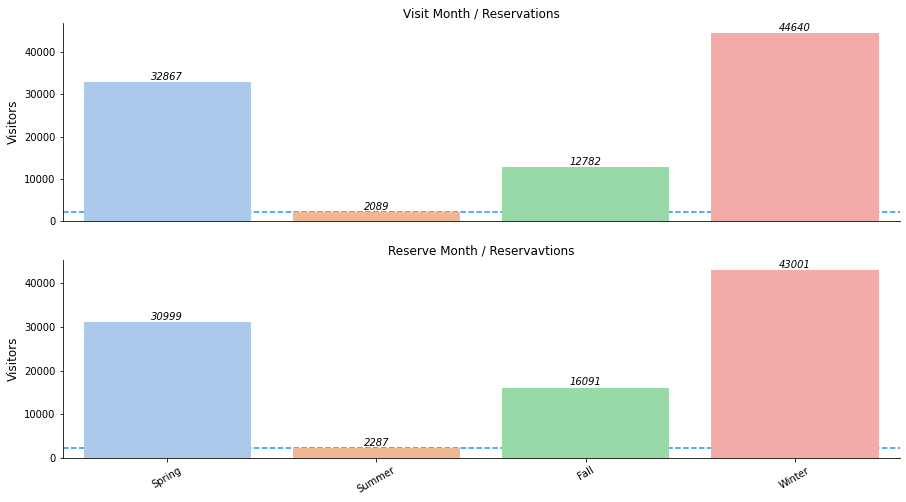

In [404]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_season_visitors_reserve_count, x="visit_datetime_season", y="reserve_count", ax=axs[0], palette=colors, zorder=2)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Month / Reservations")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[0].axhline(y = 2100, color = 'dodgerblue', ls = '--', zorder = 1)
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.barplot(data=reserve_season_visitors_reserve_count, x="reserve_datetime_season", y="reserve_count", ax=axs[1], palette=colors, zorder=2)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Month / Reservavtions")
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[1].axhline(y = 2300, color = 'dodgerblue', ls = '--', zorder = 1)
axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

##### 4. 시간대별 예약 수 정보

In [405]:
visit_hour_reserve_count = pd.pivot_table(air_reserve, index='visit_datetime_hour', values='reserve_count', aggfunc='sum').reset_index()
reserve_hour_reserve_count = pd.pivot_table(air_reserve, index='reserve_datetime_hour', values='reserve_count', aggfunc='sum').reset_index()

print(f"visit_hour_visitors has {len(visit_hour_visitors)} rows.")
print(f"reserve_hour_visitors has {len(reserve_hour_visitors)} rows.")


display(visit_hour_reserve_count)
display(reserve_hour_reserve_count)

visit_hour_visitors has 24 rows.
reserve_hour_visitors has 24 rows.


visit_datetime_hour  reserve_count
0                     0            430
1                     1            330
2                     2            189
3                     3            118
4                     4             55
5                     5             19
6                     6             12
7                     7             15
8                     8             19
9                     9             25
10                   10            316
11                   11           2979
12                   12           2806
13                   13           1606
14                   14            780
15                   15            494
16                   16           1279
17                   17           9355
18                   18          24355
19                   19          22028
20                   20          13371
21                   21           7509
22                   22           3225
23                   23           1063

reserve_datetime_hour  reserve_count
0                       0           1923
1                       1            979
2                       2            390
3                       3            234
4                       4            116
5                       5             80
6                       6            126
7                       7            348
8                       8            614
9                       9            833
10                     10           1793
11                     11           3536
12                     12           4025
13                     13           3959
14                     14           4017
15                     15           4966
16                     16           6840
17                     17          12915
18                     18          12226
19                     19           8178
20                     20           7038
21                     21           6830
22                     22           6271
23                     23           4141

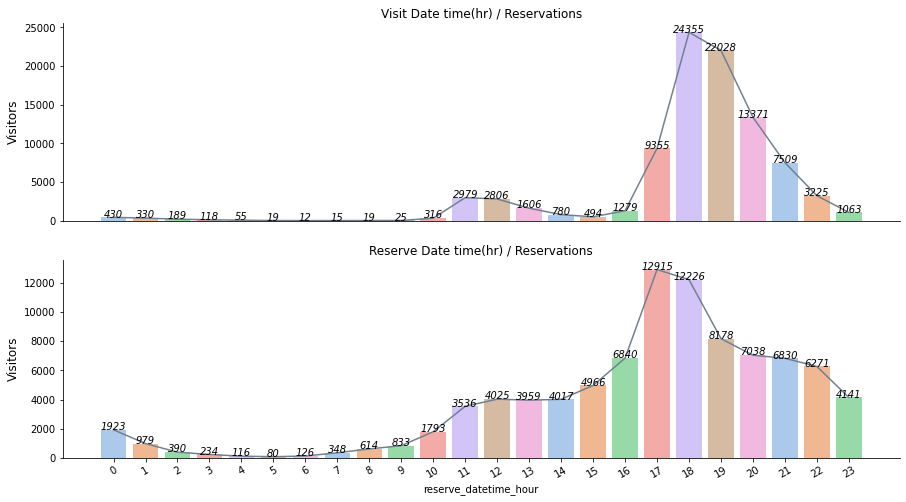

In [406]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_hour_reserve_count, x="visit_datetime_hour", y="reserve_count", ax=axs[0], palette=colors, zorder=1)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Date time(hr) / Reservations")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.lineplot(data=visit_hour_reserve_count, x="visit_datetime_hour", y="reserve_count", ax=axs[0], color='slategray', zorder=2)



sns.barplot(data=reserve_hour_reserve_count, x="reserve_datetime_hour", y="reserve_count", ax=axs[1], palette=colors, zorder=1)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Date time(hr) / Reservations")

sns.lineplot(data=reserve_hour_reserve_count, x="reserve_datetime_hour", y="reserve_count", ax=axs[1], color='slategray', zorder=2)

for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')


axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

### 2-2 Analysis of `hpg_reserve`


In [407]:
hpg_reserve.head()

hpg_store_id  ... reserve_visitors
0  hpg_c63f6f42e088e50f  ...                1
1  hpg_dac72789163a3f47  ...                3
2  hpg_c8e24dcf51ca1eb5  ...                2
3  hpg_24bb207e5fd49d4a  ...                5
4  hpg_25291c542ebb3bc2  ...               13

[5 rows x 4 columns]

In [408]:
hpg_reserve.describe()

reserve_visitors
count      2.000320e+06
mean       5.073785e+00
std        5.416172e+00
min        1.000000e+00
25%        2.000000e+00
50%        3.000000e+00
75%        6.000000e+00
max        1.000000e+02

In [409]:
hpg_reserve.isnull().sum()

hpg_store_id        0
visit_datetime      0
reserve_datetime    0
reserve_visitors    0
dtype: int64

In [410]:
hpg_reserve.dtypes

hpg_store_id        object
visit_datetime      object
reserve_datetime    object
reserve_visitors     int64
dtype: object

In [411]:
hpg_reserve['visit_datetime'] = pd.to_datetime(hpg_reserve['visit_datetime'])
hpg_reserve['reserve_datetime'] = pd.to_datetime(hpg_reserve['reserve_datetime'])

In [412]:
hpg_reserve["reserve_count"] = 1
total_reserve = pd.pivot_table(hpg_reserve, index='visit_datetime', values='reserve_count', aggfunc='sum').reset_index()
total_reserve.head(10)

visit_datetime  reserve_count
0 2016-01-01 11:00:00              1
1 2016-01-01 13:00:00              1
2 2016-01-01 16:00:00              1
3 2016-01-01 17:00:00             32
4 2016-01-01 18:00:00             44
5 2016-01-01 19:00:00             51
6 2016-01-01 20:00:00             15
7 2016-01-01 21:00:00              3
8 2016-01-01 22:00:00              4
9 2016-01-02 10:00:00              1

#### 예약 수 정보


위를 통해 결과적으로 예약 수 정보를 보는 것이 더 중요하다고 판단했으므로 예약 수 정보에 대한 것만 다뤄보겠습니다.

##### 요일별 예약 수 정보

In [413]:
visit_datetime_day = hpg_reserve['visit_datetime'].dt.day_name()
reserve_datetime_day = hpg_reserve['reserve_datetime'].dt.day_name()

In [414]:
hpg_reserve['visit_datetime_day'] = visit_datetime_day
hpg_reserve['reserve_datetime_day'] = reserve_datetime_day

In [415]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
visit_day_reserve_count = pd.pivot_table(hpg_reserve, index='visit_datetime_day', values='reserve_count', aggfunc='sum').reindex(days).reset_index()
reserve_day_reserve_count = pd.pivot_table(hpg_reserve, index='reserve_datetime_day', values='reserve_count', aggfunc='sum').reindex(days).reset_index()

print(f"visit_day_reserve_count has {len(visit_day_reserve_count)} rows.")
print(f"reserve_day_reserve_count has {len(reserve_day_reserve_count)} rows.")


display(visit_day_reserve_count)
display(reserve_day_reserve_count)

visit_day_reserve_count has 7 rows.
reserve_day_reserve_count has 7 rows.


visit_datetime_day  reserve_count
0             Monday         160478
1            Tuesday         183173
2          Wednesday         229615
3           Thursday         230030
4             Friday         480663
5           Saturday         487896
6             Sunday         228465

reserve_datetime_day  reserve_count
0               Monday         295632
1              Tuesday         319451
2            Wednesday         319980
3             Thursday         322660
4               Friday         288044
5             Saturday         232437
6               Sunday         222116

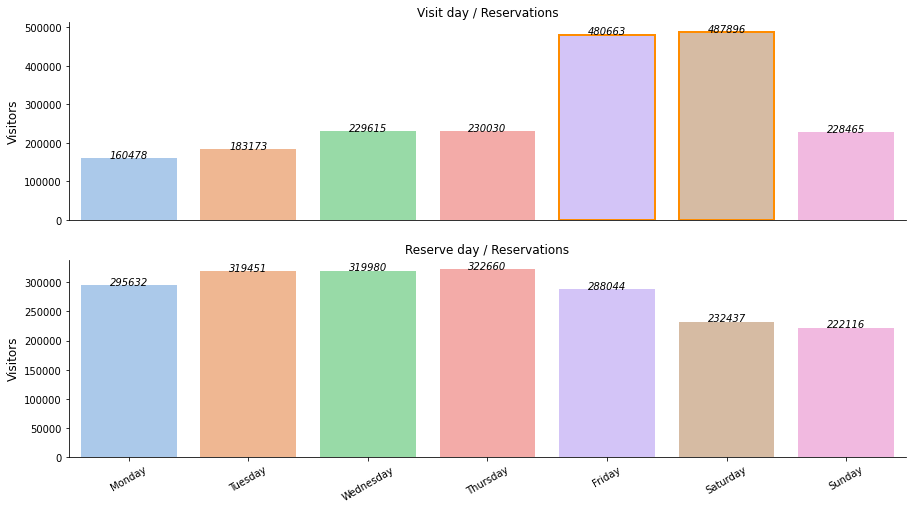

In [416]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_day_reserve_count, x="visit_datetime_day", y="reserve_count", ax=axs[0], palette=colors)

axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit day / Reservations") # 해당요일에 방문하겠다고 한 예약수 
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')

axs[0].patches[4].set_linewidth('2')
axs[0].patches[4].set_edgecolor('darkorange')
axs[0].patches[5].set_linewidth('2')
axs[0].patches[5].set_edgecolor('darkorange')

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.barplot(data=reserve_day_reserve_count, x="reserve_datetime_day", y="reserve_count", ax=axs[1], palette=colors)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve day / Reservations") # 예약이 온 요일
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

##### 월별 예약 수 정보



In [417]:
visit_datetime_month = hpg_reserve['visit_datetime'].dt.month_name()
reserve_datetime_month = hpg_reserve['reserve_datetime'].dt.month_name()
hpg_reserve['visit_datetime_month'] = visit_datetime_month
hpg_reserve['reserve_datetime_month'] = reserve_datetime_month

In [418]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
visit_month_reserve_count = pd.pivot_table(hpg_reserve, index='visit_datetime_month', values='reserve_count', aggfunc='sum').reindex(months).reset_index()
reserve_month_reserve_count = pd.pivot_table(hpg_reserve, index='reserve_datetime_month', values='reserve_count', aggfunc='sum').reindex(months).reset_index()

print(f"visit_month_reserve_count has {len(visit_month_reserve_count)} rows.")
print(f"reserve_month_reserve_count has {len(reserve_month_reserve_count)} rows.")


display(visit_month_reserve_count)
display(reserve_month_reserve_count)

visit_month_reserve_count has 12 rows.
reserve_month_reserve_count has 12 rows.


visit_datetime_month  reserve_count
0               January         213202
1              February         230824
2                 March         296549
3                 April         237858
4                   May          99102
5                  June          90924
6                  July         102587
7                August         101721
8             September         101845
9               October         110696
10             November         125134
11             December         289878

reserve_datetime_month  reserve_count
0                 January         234560
1                February         233035
2                   March         293894
3                   April         221179
4                     May          86314
5                    June          94411
6                    July          99932
7                  August         101262
8               September         102974
9                 October         118589
10               November         170466
11               December         243704

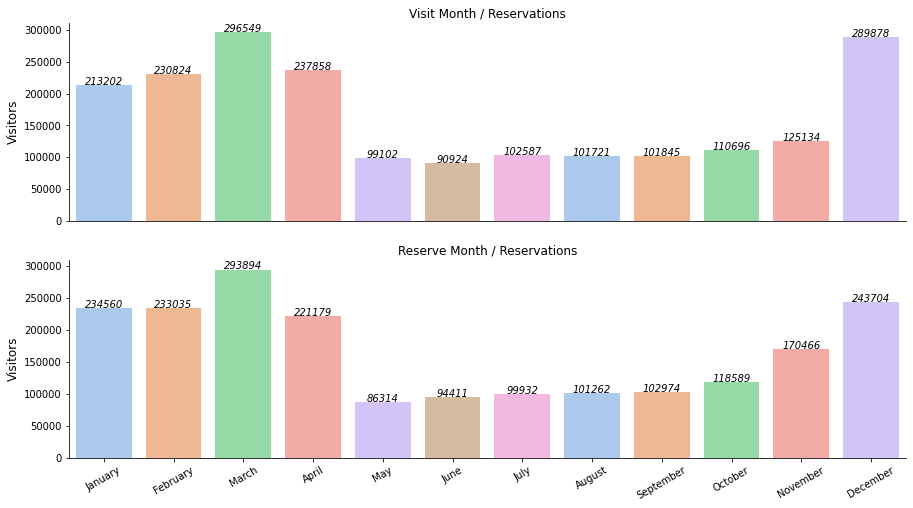

In [419]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_month_reserve_count, x="visit_datetime_month", y="reserve_count", ax=axs[0], palette=colors, zorder=2)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Month / Reservations")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')
axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.barplot(data=reserve_month_reserve_count, x="reserve_datetime_month", y="reserve_count", ax=axs[1], palette=colors, zorder=2)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Month / Reservations")
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

##### 3. 계절별 예약 수 정보

In [420]:
hpg_reserve['visit_datetime_season'] = ""
hpg_reserve['reserve_datetime_season'] = ""

In [421]:
hpg_reserve['visit_datetime_season'] = np.where(hpg_reserve['visit_datetime_month'].isin(["March", "April", "May"]), 'Spring', hpg_reserve['visit_datetime_season'])
hpg_reserve['visit_datetime_season'] = np.where(hpg_reserve['visit_datetime_month'].isin(["June", "July", "August"]), 'Summer', hpg_reserve['visit_datetime_season'])
hpg_reserve['visit_datetime_season'] = np.where(hpg_reserve['visit_datetime_month'].isin(["September", "October", "November"]), 'Fall', hpg_reserve['visit_datetime_season'])
hpg_reserve['visit_datetime_season'] = np.where(hpg_reserve['visit_datetime_month'].isin(["December", "January", "February"]), 'Winter', hpg_reserve['visit_datetime_season'])

In [422]:
hpg_reserve['reserve_datetime_season'] = np.where(hpg_reserve['reserve_datetime_month'].isin(["March", "April", "May"]), 'Spring', hpg_reserve['reserve_datetime_season'])
hpg_reserve['reserve_datetime_season'] = np.where(hpg_reserve['reserve_datetime_month'].isin(["June", "July", "August"]), 'Summer', hpg_reserve['reserve_datetime_season'])
hpg_reserve['reserve_datetime_season'] = np.where(hpg_reserve['reserve_datetime_month'].isin(["September", "October", "November"]), 'Fall', hpg_reserve['reserve_datetime_season'])
hpg_reserve['reserve_datetime_season'] = np.where(hpg_reserve['reserve_datetime_month'].isin(["December", "January", "February"]), 'Winter', hpg_reserve['reserve_datetime_season'])

In [423]:
seasons = ['Spring', 'Summer', 'Fall', 'Winter']
visit_season_visitors_reserve_count = pd.pivot_table(hpg_reserve, index='visit_datetime_season', values='reserve_count', aggfunc='sum').reindex(seasons).reset_index()
reserve_season_visitors_reserve_count = pd.pivot_table(hpg_reserve, index='reserve_datetime_season', values='reserve_count', aggfunc='sum').reindex(seasons).reset_index()

print(f"visit_season_visitors_reserve_count has {len(visit_season_visitors_reserve_count)} rows.")
print(f"reserve_season_visitors_reserve_count has {len(reserve_season_visitors_reserve_count)} rows.")


display(visit_season_visitors_reserve_count)
display(reserve_season_visitors_reserve_count)

visit_season_visitors_reserve_count has 4 rows.
reserve_season_visitors_reserve_count has 4 rows.


visit_datetime_season  reserve_count
0                Spring         633509
1                Summer         295232
2                  Fall         337675
3                Winter         733904

reserve_datetime_season  reserve_count
0                  Spring         601387
1                  Summer         295605
2                    Fall         392029
3                  Winter         711299

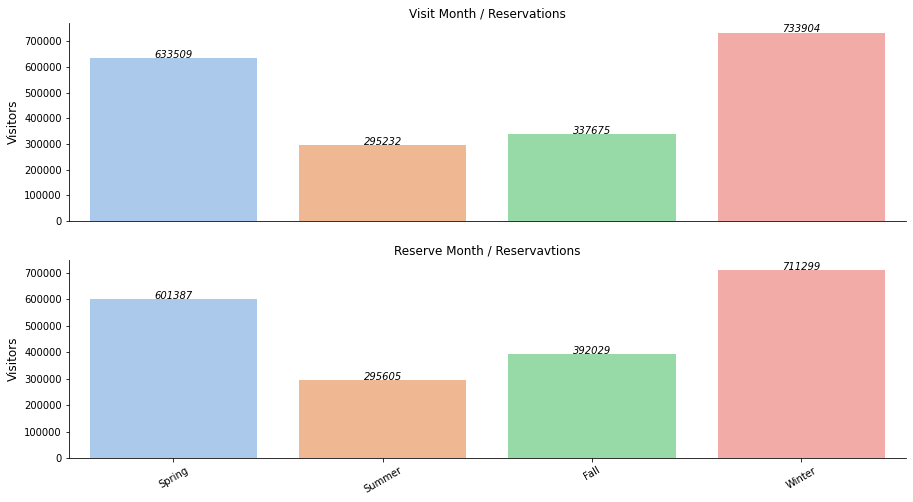

In [424]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_season_visitors_reserve_count, x="visit_datetime_season", y="reserve_count", ax=axs[0], palette=colors, zorder=2)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Month / Reservations")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')


axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)


sns.barplot(data=reserve_season_visitors_reserve_count, x="reserve_datetime_season", y="reserve_count", ax=axs[1], palette=colors, zorder=2)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Month / Reservavtions")
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+500), ha = 'center', color = 'k', style='italic')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

##### 4. 시간대별 예약 수 정보

In [425]:
hpg_reserve["reserve_datetime_hour"] = hpg_reserve["reserve_datetime"].dt.hour
hpg_reserve["visit_datetime_hour"] = hpg_reserve["visit_datetime"].dt.hour

In [426]:
visit_hour_reserve_count = pd.pivot_table(hpg_reserve, index='visit_datetime_hour', values='reserve_count', aggfunc='sum').reset_index()
reserve_hour_reserve_count = pd.pivot_table(hpg_reserve, index='reserve_datetime_hour', values='reserve_count', aggfunc='sum').reset_index()

print(f"visit_hour_visitors has {len(visit_hour_visitors)} rows.")
print(f"reserve_hour_visitors has {len(reserve_hour_visitors)} rows.")


display(visit_hour_reserve_count)
display(reserve_hour_reserve_count)

visit_hour_visitors has 24 rows.
reserve_hour_visitors has 24 rows.


visit_datetime_hour  reserve_count
0                     0           2057
1                     1           1387
2                     2            519
3                     3            201
4                     4            162
5                     5           1055
6                     6           3218
7                     7           2484
8                     8            779
9                     9            677
10                   10           1612
11                   11          52960
12                   12          74108
13                   13          34930
14                   14          10006
15                   15           7482
16                   16          13877
17                   17         150696
18                   18         643665
19                   19         723550
20                   20         195548
21                   21          59577
22                   22          15125
23                   23           4645

reserve_datetime_hour  reserve_count
0                       0          67206
1                       1          30881
2                       2          13656
3                       3           7007
4                       4           5005
5                       5           5942
6                       6          13893
7                       7          33454
8                       8          54457
9                       9          60886
10                     10          73317
11                     11          85983
12                     12         134169
13                     13         114184
14                     14         101385
15                     15         105003
16                     16         118146
17                     17         127502
18                     18         141675
19                     19         135719
20                     20         142600
21                     21         153917
22                     22         151399
23                     23         122934

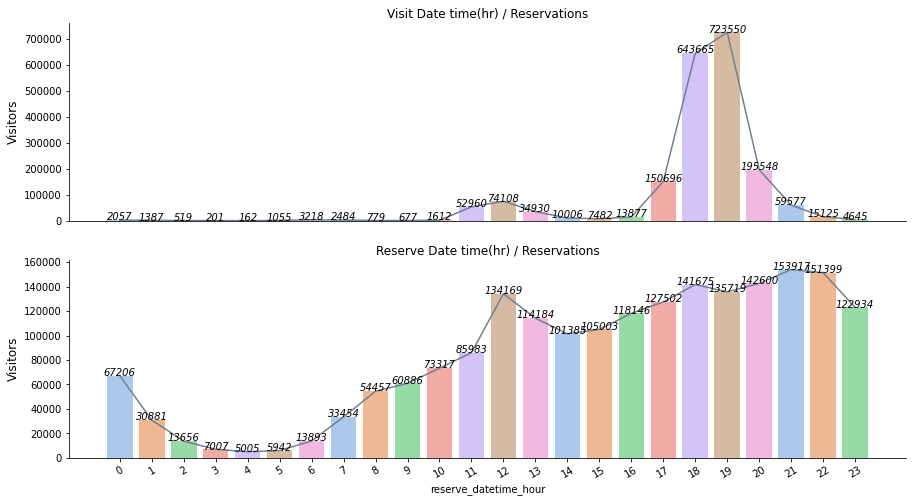

In [427]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 8))
axs = axes.ravel()
sns.barplot(data=visit_hour_reserve_count, x="visit_datetime_hour", y="reserve_count", ax=axs[0], palette=colors, zorder=1)
axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xticks([])
axs[0].set_xlabel("")
axs[0].set_title("Visit Date time(hr) / Reservations")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')

axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.lineplot(data=visit_hour_reserve_count, x="visit_datetime_hour", y="reserve_count", ax=axs[0], color='slategray', zorder=2)



sns.barplot(data=reserve_hour_reserve_count, x="reserve_datetime_hour", y="reserve_count", ax=axs[1], palette=colors, zorder=1)
axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=30)
axs[1].set_xlabel("")
axs[1].set_title("Reserve Date time(hr) / Reservations")

sns.lineplot(data=reserve_hour_reserve_count, x="reserve_datetime_hour", y="reserve_count", ax=axs[1], color='slategray', zorder=2)

for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')


axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

##### * `air_reserve` vs `air_visit_data`

In [428]:
reserve_id = air_reserve["air_store_id"].to_numpy()
visit_id = air_visit_data["air_store_id"].to_numpy()
print(f"air_reserve_data의 id 갯수: {len(np.unique(air_reserve['air_store_id'].to_numpy()))}")
print(f"air_visit_data의 id 갯수: {len(np.unique(air_visit_data['air_store_id'].to_numpy()))}")

air_reserve_data의 id 갯수: 314
air_visit_data의 id 갯수: 829


In [429]:
print(f"{len(set(visit_id) - set(reserve_id))}개의 매장은 정보가 없습니다.") ## 515개의 정보가 없다고 보는 것이 좋을 것 같다.
print(f"len(set(reserve_id) - set(visit_id)) = {len(set(reserve_id) - set(visit_id))}인 것을 보면 air_visit_data는 air_reserve의 모든 매장을 포함합니다.")
print(f"16. 01. 03의 총 방문객: {air_visit_data[air_visit_data['visit_date'] == '2016-01-13']['visitors'].sum()}") ## visit_data의 합
print(f"16. 01. 03의 예약 방문객: {air_reserve.iloc[599:681, 3].sum()}") ## reserve의 합

515개의 매장은 정보가 없습니다.
len(set(reserve_id) - set(visit_id)) = 0인 것을 보면 air_visit_data는 air_reserve의 모든 매장을 포함합니다.
16. 01. 03의 총 방문객: 4848
16. 01. 03의 예약 방문객: 388


515개의 예약정보가 없는 매장이 있을 수 있으므로 `air_reserve`에 정보가 있는 매장에 대한 visit_data를 따로 뽑아내겠습니다.

In [430]:
air_reserved_visit_data = air_visit_data[air_visit_data["air_store_id"].isin(reserve_id)]

In [431]:
air_reserved_visit_data[air_reserved_visit_data['visit_date'] == '2016-01-13']['visitors'].sum()

1779

두 데이터는 비슷한 분포를 보이지만 그 갯수에서 확연한 차이를 보입니다. 평균적으로 `hpg`에 등록되어있는 데이터들이 훨씬 많은 방문객 수, 예약 수를 보이고 있습니다. 따라서 추후에 데이터를 합치더라도 어떤 서비스에서 온 데이터인지 명시하는 것이 중요할 것으로 예상됩니다.

또한 EDA 중에 노쇼 고객이 있을 것을 염두에 두고 미리 `air_reserve`와 `air_visit_data`를 이용해 구하려고 했지만 노쇼한 인원을 파악하는 것은 불가능해 보입니다. 이유는 `air_reserve`에서 센 방문예정객 수가 `air_visit_data`에서 센 실제 방문객 수보다 많다면 노쇼라고 할 수 있지만 적다고 해서 노쇼를 하지 않았다고는 할 수 없기 떄문입니다. 하지만 이러한 $\frac{\text{실제 방문객}}{\text{방문 예정객}}$의 비율을 이용한다면 유동인구 파악, 또는 위도/경도의 정보와 함께 번화가와 그렇지 시외지역간의 비율차이를 이용해 유의미한 분석을 할 수 있을 것 같습니다.

무엇보다 이런 분석은 예약 데이터만을 모아놓은 데이터셋을 바라보고 가정적으로 생각을 하고 있는 부분이기 때문에 `store_info`에 대한 분석을 필요로 합니다. 따라서 이어지는 과정에서 `store_info`에 관한 EDA를 이어가겠습니다.

### 2-3 Analysis of `air_store_info`


In [432]:
air_store_info.head()

air_store_id  air_genre_name  ...   latitude   longitude
0  air_0f0cdeee6c9bf3d7  Italian/French  ...  34.695124  135.197852
1  air_7cc17a324ae5c7dc  Italian/French  ...  34.695124  135.197852
2  air_fee8dcf4d619598e  Italian/French  ...  34.695124  135.197852
3  air_a17f0778617c76e2  Italian/French  ...  34.695124  135.197852
4  air_83db5aff8f50478e  Italian/French  ...  35.658068  139.751599

[5 rows x 5 columns]

In [433]:
air_store_info.describe()

latitude   longitude
count  829.000000  829.000000
mean    35.647042  137.415311
std      2.084659    3.650971
min     33.211967  130.195555
25%     34.695124  135.341564
50%     35.658068  139.685474
75%     35.694003  139.751599
max     44.020632  144.273398

In [434]:
air_store_info.isnull().sum()

air_store_id      0
air_genre_name    0
air_area_name     0
latitude          0
longitude         0
dtype: int64

기본적으로 살펴보니 결측치나 기타 이상은 없는 것 같습니다. id는 단지 고유적인 값일 뿐이니 장르(음식 종류)이름부터 하나씩 살펴보겠습니다.

#### 음식 종류(장르) 정보

In [435]:
air_genre_count = air_store_info["air_genre_name"].value_counts(ascending=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


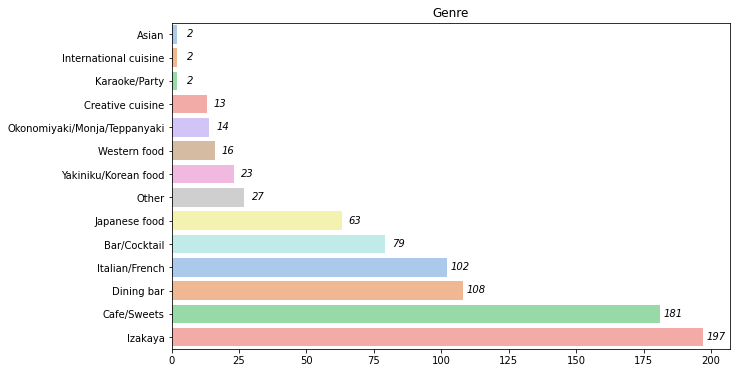

In [436]:
colors = sns.color_palette("pastel", len(air_genre_count))
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(air_genre_count.values, air_genre_count.index, ax=ax, palette=colors)
ax.set_title("Genre")


for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(int(width), (width+5, bottom+0.5), ha = 'center', color = 'k', style='italic')

장르를 살펴보면 이자카야가 가장 많고 그 뒤를 카페, 다이닝 바가 있으며 아시안, 카라오케/파티, 세계요리(international cuisine)이 2개로 최하위에 위치해있습니다. 장르에 관련된 사항은 위에서 방문 예정자, 예약건수를 다룰 때에 hue 값으로 구분해서 사용하면 아주 요긴하게 사용할 수 있을 것 같습니다.

#### 매장 위도, 경도 정보
위도와 경도에 대한 분석을 해보겠습니다.

In [437]:
air_store_info.head()

air_store_id  air_genre_name  ...   latitude   longitude
0  air_0f0cdeee6c9bf3d7  Italian/French  ...  34.695124  135.197852
1  air_7cc17a324ae5c7dc  Italian/French  ...  34.695124  135.197852
2  air_fee8dcf4d619598e  Italian/French  ...  34.695124  135.197852
3  air_a17f0778617c76e2  Italian/French  ...  34.695124  135.197852
4  air_83db5aff8f50478e  Italian/French  ...  35.658068  139.751599

[5 rows x 5 columns]

<Figure size 864x864 with 0 Axes>

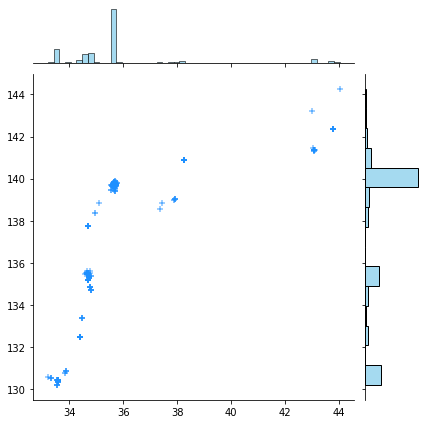

In [438]:
plt.figure(figsize=(12, 12))
g = sns.jointplot(x=air_store_info.latitude.values, y=air_store_info.longitude.values, marker="+",
                  color='dodgerblue', marginal_kws=dict(color='skyblue'))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

jointplot을 이용해 산점도와 분포를 보여주는 히스토그램을 그려보았지만 크게 인사이트를 얻기 힘들어 보입니다. 가장 많은 데이터가 경도 140, 위도 36근방에 가장 많이 위치하고 있으니 어떤 곳인지 한번 확인해보겠습니다.

In [439]:
from collections import Counter

freq_lat = air_store_info[(35 < air_store_info["latitude"]) & (air_store_info["latitude"] < 37)]
freq_long = air_store_info[(139 < air_store_info["longitude"]) & (air_store_info["longitude"] < 141)]

freq_lat_list = freq_lat['air_area_name'].to_numpy()
freq_long_list = freq_long['air_area_name'].to_numpy()

freq_lat_list = [address.split()[0] for address in freq_lat_list]
freq_long_list = [address.split()[0] for address in freq_long_list]

print(Counter(freq_lat_list))
print(Counter(freq_long_list))

Counter({'Tōkyō-to': 444, 'Shizuoka-ken': 2})
Counter({'Tōkyō-to': 444, 'Miyagi-ken': 17, 'Niigata-ken': 7})


위도 36근방, 경도 140근방의 주소의 첫 단어를 통해 어떤 도, 현에 있는 지 뽑아보니 대부분이 도쿄에 위치해있고 시즈오카현, 미야기현, 니이가타현에 조금씩 분포하고 있습니다. 다시 그림을 보면 대부분의 데이터가 아얘 위도 36, 경도 140에 위치하고 있는데 이는 실제 도쿄의 위도, 경도인 (35.652, 139.839)와 매우 비슷한 위치입니다.

위도, 경도에 해당하는 위치에 산점도로 점을 찍고 어떤 종류의 음식을 파는 지 구분하기 위해 그려본 그림입니다.

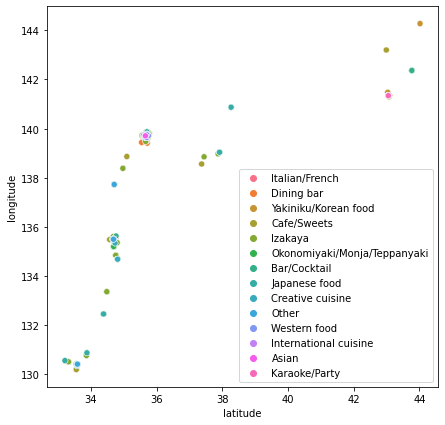

In [440]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.scatterplot(data=air_store_info, x='latitude', y='longitude', hue='air_genre_name', ax=ax)
ax.legend(loc='lower right')

자세히 보이지는 않지만 도쿄 부근에는 다양한 음식점이 혼재하고 있다는 점, 그리고 또 다른 식당이 혼재하고 있는 위도 35, 경도 135 부근은 오사카라는 점을 알 수 있습니다. (실제 오사카의 위도: 34.41, 경도: 135.30)

산점도를 통해 어떤 곳에 음식점이 많이 위치하고 있는 지에 대한 정보는 알 수 있지만 전반적인 음식 종류의 분포에 대해서는 알아보기가 힘든 단점이 있습니다.

#### 매장 위치 정보

매장 위치 정보를 우선 음식 종류 정보와 연결시켜 분석해보겠습니다. 번거롭지만 매장에 해당하는 음식 종류수를 세어주기 위해 데이터프레임을 하나씩 만들었습니다.

In [441]:
air_IF_store = air_store_info[air_store_info["air_genre_name"] == "Italian/French"]
air_BC_store = air_store_info[air_store_info["air_genre_name"] == "Bar/Cocktail"]
air_CS_store = air_store_info[air_store_info["air_genre_name"] == "Cafe/Sweets"]
air_CC_store = air_store_info[air_store_info["air_genre_name"] == "Creative cuisine"]
air_DB_store = air_store_info[air_store_info["air_genre_name"] == "Dining bar"]
air_IC_store = air_store_info[air_store_info["air_genre_name"] == "International cuisine"]
air_IZ_store = air_store_info[air_store_info["air_genre_name"] == "Izakaya"]
air_JA_store = air_store_info[air_store_info["air_genre_name"] == "Japanese food"]
air_KA_store = air_store_info[air_store_info["air_genre_name"] == "Karaoke/Party"]
air_YA_store = air_store_info[air_store_info["air_genre_name"] == "Okonomiyaki/Monja/Teppanyaki"]
air_OT_store = air_store_info[air_store_info["air_genre_name"] == "Other"]
air_WE_store = air_store_info[air_store_info["air_genre_name"] == "Western food"]
air_KO_store = air_store_info[air_store_info["air_genre_name"] == "Yakiniku/Korean food"]
air_AS_store = air_store_info[air_store_info["air_genre_name"] == "Asian"]

In [442]:
air_IF_count = air_IF_store["air_area_name"].value_counts()
air_BC_count = air_BC_store["air_area_name"].value_counts()
air_CS_count = air_CS_store["air_area_name"].value_counts()
air_CC_count = air_CC_store["air_area_name"].value_counts()
air_DB_count = air_DB_store["air_area_name"].value_counts()
air_IC_count = air_IC_store["air_area_name"].value_counts()
air_IZ_count = air_IZ_store["air_area_name"].value_counts()
air_JA_count = air_JA_store["air_area_name"].value_counts()
air_KA_count = air_KA_store["air_area_name"].value_counts()
air_YA_count = air_YA_store["air_area_name"].value_counts()
air_OT_count = air_OT_store["air_area_name"].value_counts()
air_WE_count = air_WE_store["air_area_name"].value_counts()
air_KO_count = air_KO_store["air_area_name"].value_counts()
air_AS_count = air_AS_store["air_area_name"].value_counts()

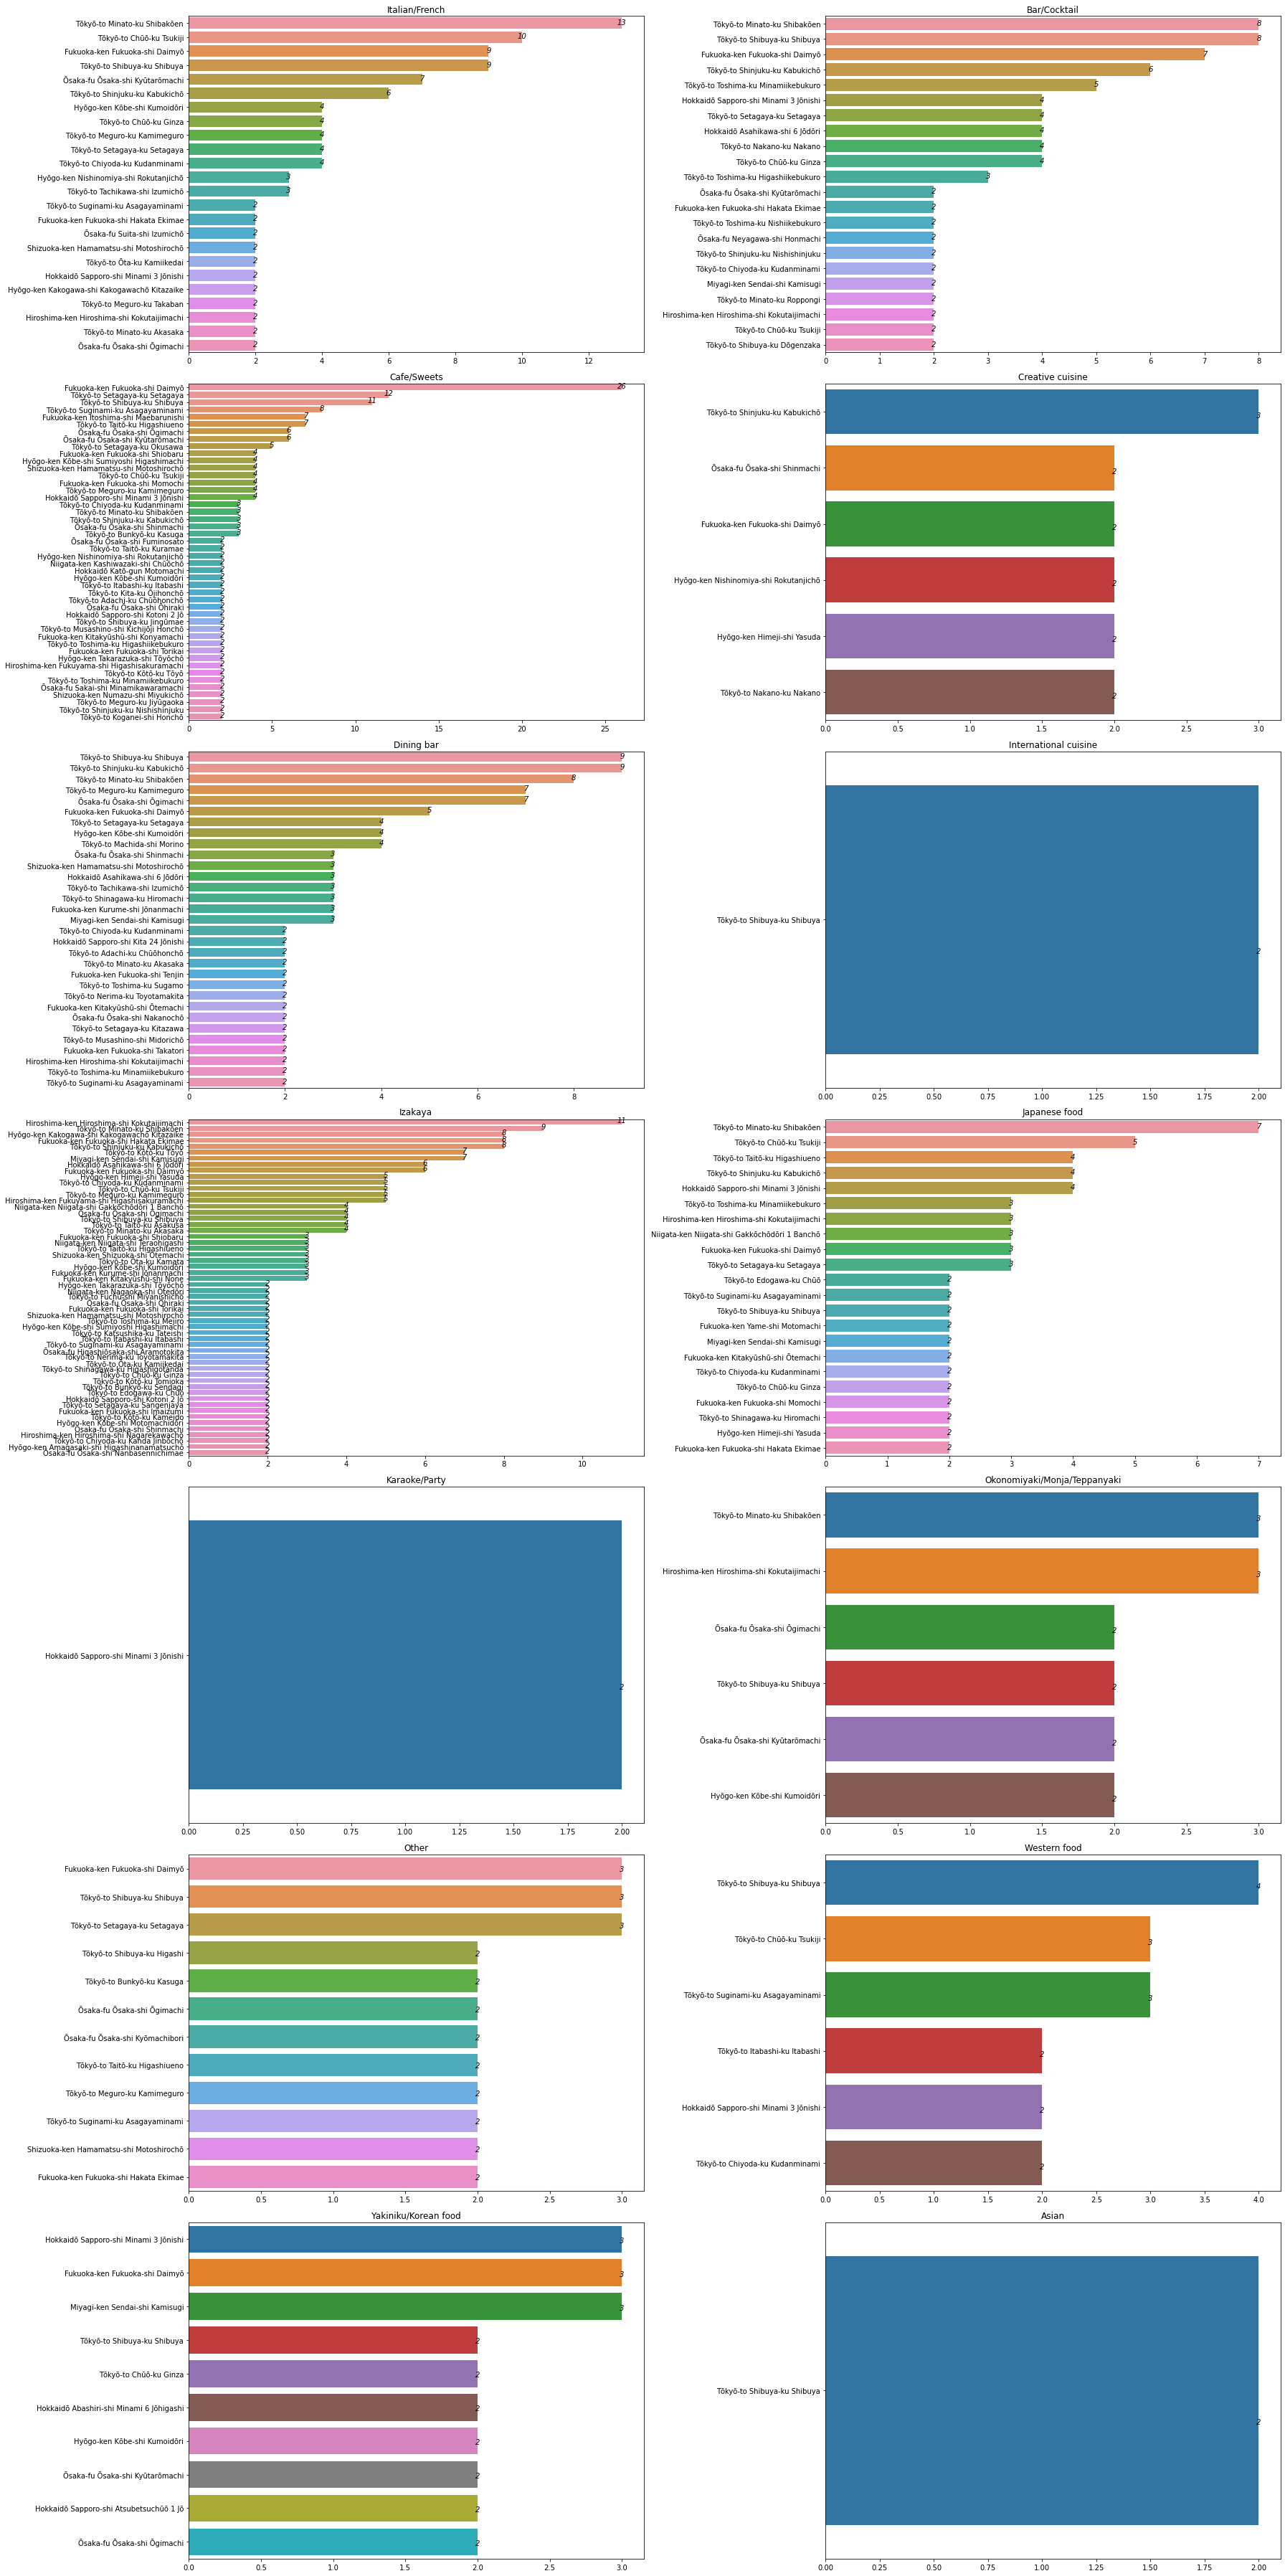

In [443]:
count_list = [air_IF_count, air_BC_count, air_CS_count, air_CC_count, air_DB_count, air_IC_count, air_IZ_count, 
              air_JA_count, air_KA_count, air_YA_count, air_OT_count, air_WE_count, air_KO_count, air_AS_count]
name_list = ['Italian/French', 'Bar/Cocktail', 'Cafe/Sweets', 'Creative cuisine', 'Dining bar', 'International cuisine', 
             'Izakaya', 'Japanese food', 'Karaoke/Party', 'Okonomiyaki/Monja/Teppanyaki', 'Other', 
             'Western food', 'Yakiniku/Korean food', 'Asian']

fig, axes = plt.subplots(figsize=(25, 50), nrows=7, ncols=2)
axs = axes.ravel()
for i, ax in enumerate(axs):
    sns.barplot(y=count_list[i].index, x=count_list[i].values, ax=ax)
    ax.set_title(f"{name_list[i]}")
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        ax.annotate(int(width), (width, bottom+0.5), ha = 'center', color = 'k', style='italic')

fig.tight_layout()

위와 같은 막대 그래프로 봤을 때, 특히나 카페, 다이닝 바, 이자카야 등은 여러 도시에 걸쳐 위치하고 있고 세계요리, 카라오케, 아시안의 경우 한 지역에만 위치하고 있음을 알 수 있습니다.

계속 염두에 둬야 하는 것은 air 플랫폼에 등록된 매장에 한해서 모아진 정보이므로 전체적인 매장의 구성은 hpg와 함께 보는 것이 더 좋아보입니다.

각 지역마다 어떤 종류의 음식점이 몇개씩 있는지에 대한 분포를 알아보기 위해 히트맵을 이용해보겠습니다.

In [444]:
area_genre = pd.pivot_table(air_store_info, index='air_area_name', columns='air_genre_name', aggfunc='size').fillna(0).astype(np.int8)

In [445]:
area_genre.head()

air_genre_name                         Asian  ...  Yakiniku/Korean food
air_area_name                                 ...                      
Fukuoka-ken Fukuoka-shi Daimyō             0  ...                     3
Fukuoka-ken Fukuoka-shi Hakata Ekimae      0  ...                     0
Fukuoka-ken Fukuoka-shi Imaizumi           0  ...                     0
Fukuoka-ken Fukuoka-shi Momochi            0  ...                     0
Fukuoka-ken Fukuoka-shi Shiobaru           0  ...                     0

[5 rows x 14 columns]

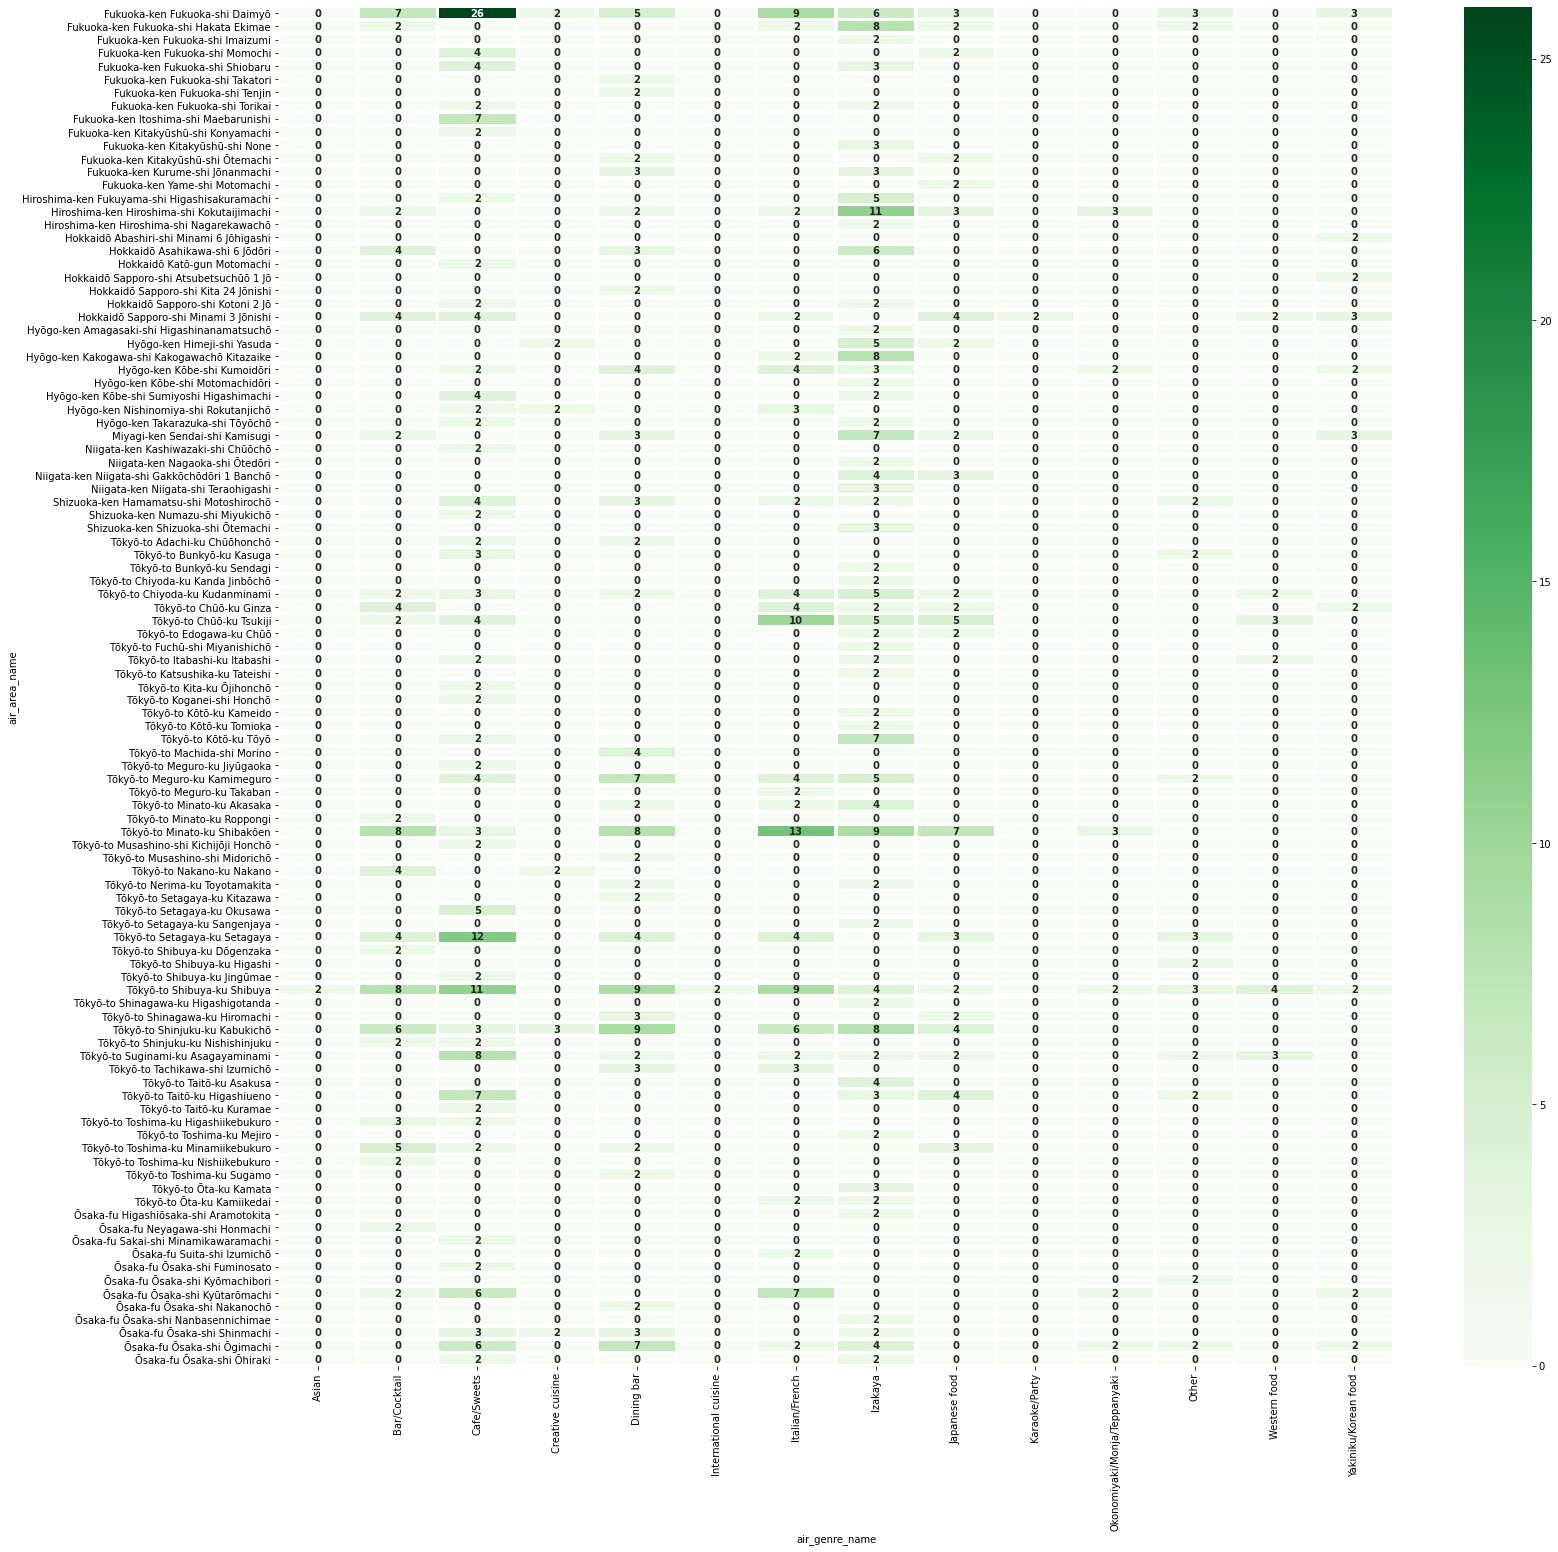

In [446]:
fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(area_genre, ax=ax, linewidths=2.5, annot=True, annot_kws={"size": 10, "fontweight": 'bold'}, cmap="Greens", fmt="d")

각 지역별로 어떤 종류의 음식을 파는 매장이 많이 놓여있는 지 볼 수 있습니다. 반대로 음식 종류의 지역적인 분포를 알고 싶다면 데이터프레임의 전치(transpose)를 이용하면 좀 더 쉽게 볼 수 있습니다.

### 2-4 Analysis of hpg_store_info

In [447]:
hpg_store_info.head()

hpg_store_id  hpg_genre_name  ...   latitude   longitude
0  hpg_6622b62385aec8bf  Japanese style  ...  35.643675  139.668221
1  hpg_e9e068dd49c5fa00  Japanese style  ...  35.643675  139.668221
2  hpg_2976f7acb4b3a3bc  Japanese style  ...  35.643675  139.668221
3  hpg_e51a522e098f024c  Japanese style  ...  35.643675  139.668221
4  hpg_e3d0e1519894f275  Japanese style  ...  35.643675  139.668221

[5 rows x 5 columns]

In [448]:
hpg_store_info.describe()

latitude    longitude
count  4690.000000  4690.000000
mean     35.810261   137.675816
std       2.138755     3.197233
min      33.311645   130.339313
25%      34.692109   135.498859
50%      35.659214   139.495733
75%      35.703381   139.737998
max      43.774846   143.714585

In [449]:
hpg_store_info.isnull().sum()

hpg_store_id      0
hpg_genre_name    0
hpg_area_name     0
latitude          0
longitude         0
dtype: int64

위와 같은 순서로 장르(음식 종류)이름부터 하나씩 살펴보겠습니다.

#### 음식 종류(장르) 정보

In [450]:
hpg_genre_count = hpg_store_info["hpg_genre_name"].value_counts(ascending=True)

In [451]:
hpg_genre_count.index.to_numpy()

array(['Shanghai food', 'Spain/Mediterranean cuisine',
       'Taiwanese/Hong Kong cuisine', 'Udon/Soba', 'Sweets',
       'Dim Sum/Dumplings', 'Sichuan food', 'Cantonese food',
       'Thai/Vietnamese food', 'Western food', 'Amusement bar',
       'Bar/Cocktail', 'Pasta/Pizza', 'Sushi', 'Cafe', 'Bistro',
       'Steak/Hamburger/Curry', 'French', 'Korean cuisine', 'Party',
       'Okonomiyaki/Monja/Teppanyaki', 'Shabu-shabu/Sukiyaki',
       'Creative Japanese food', 'Karaoke', 'Japanese cuisine/Kaiseki',
       'Japanese food in general', 'Chinese general',
       'Spain Bar/Italian Bar', 'Italian', 'Grilled meat', 'Seafood',
       'Creation', 'International cuisine', 'Japanese style'],
      dtype=object)

살펴보니 air의 경우보다 더 많은 종류의 음식이 담겨있습니다.

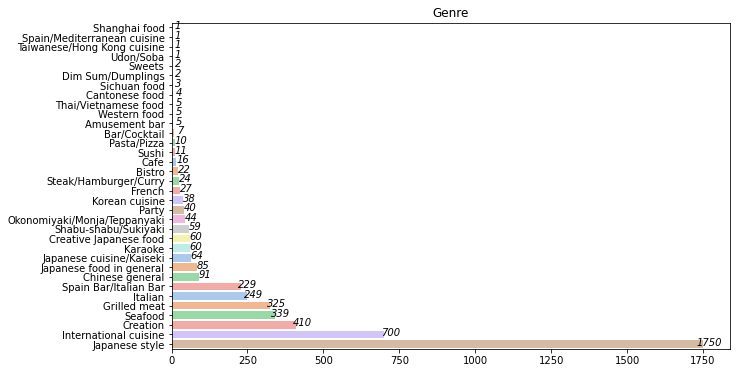

In [452]:
colors = sns.color_palette("pastel", len(air_genre_count))
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=hpg_genre_count.values, y=hpg_genre_count.index, ax=ax, palette=colors)
ax.set_title("Genre")


for p in ax.patches:
    left, bottom, width, height = p.get_bbox().bounds
    ax.annotate(int(width), (width+20, bottom+0.5), ha = 'center', color = 'k', style='italic')

장르를 살펴보면 일본식이 가장 많고 그 뒤를 세계요리(international cuisine)이 creation(창작요리)가 위치해있습니다. 최하위에는 스페인/지중해 요리, 대만/홍콩 요리, 상하이 음식 순으로 놓여있습니다. 

살펴보면 우동/소바, 스시의 경우 등을 별도로 분류해 일식에 넣지 않았다는 점, air와 달리 cafe와 sweets가 빠져있다는 점 등을 주목해서 보면 좋을 것 같습니다.

이 경우에도 hue 값으로 구분해서 사용하면 아주 요긴하게 사용할 수 있을 것 같습니다.

#### 매장 위도, 경도 정보
위도와 경도에 대한 분석을 해보겠습니다.

<Figure size 864x864 with 0 Axes>

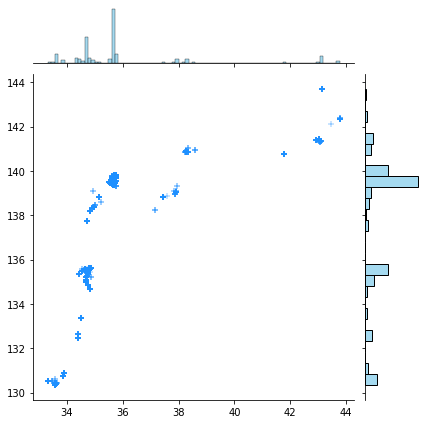

In [453]:
plt.figure(figsize=(12, 12))
g = sns.jointplot(x=hpg_store_info.latitude.values, y=hpg_store_info.longitude.values, marker="+",
                  color='dodgerblue', marginal_kws=dict(color='skyblue'))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

위와 비슷하게 장 많은 데이터가 경도 140, 위도 36 근방인 도쿄, 그리고 경도 135, 위도 35근방인 오사카에 많이 모여있는 것을 알 수 있습니다.

위도 36근방, 경도 140근방의 주소의 첫 단어를 통해 어떤 도, 현에 있는 지 뽑아보니 대부분이 도쿄에 위치해있고 시즈오카현, 미야기현, 니이가타현에 조금씩 분포하고 있습니다. 다시 그림을 보면 대부분의 데이터가 아얘 위도 36, 경도 140에 위치하고 있는데 이는 실제 도쿄의 위도, 경도인 (35.652, 139.839)와 매우 비슷한 위치입니다.

위도, 경도에 해당하는 위치에 산점도로 점을 찍고 어떤 종류의 음식을 파는 지 구분하기 위해 그려본 그림입니다.

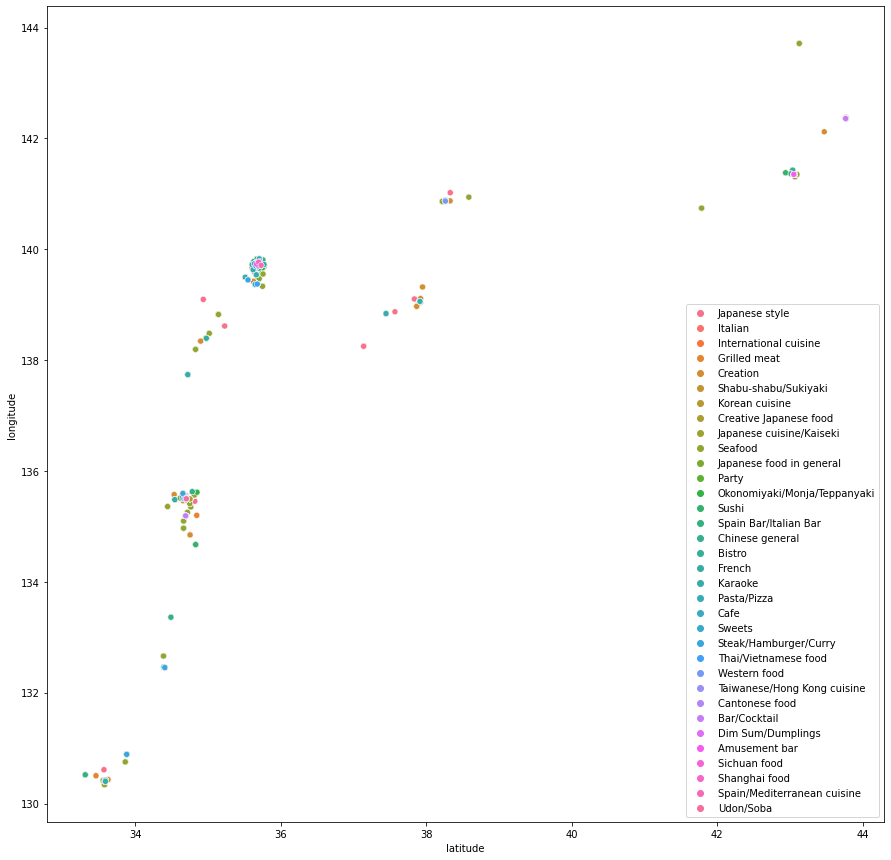

In [454]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.scatterplot(data=hpg_store_info, x='latitude', y='longitude', hue='hpg_genre_name', ax=ax)
ax.legend(loc='lower right')

이 경우도 air의 경우와 비슷하게 음식점의 전반적인 분포, 음식점이 많이 몰린 곳에는 종류도 다양할 것으로 추측된다는 가정을 생각할 수 있습니다.

#### 매장 위치 정보

매장 위치 정보를 우선 음식 종류 정보와 연결시켜 분석해보겠습니다. 번거롭지만 매장에 해당하는 음식 종류수를 세어주기 위해 데이터프레임을 하나씩 만들었습니다.

In [455]:
hpg_JS_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Japanese style"]
hpg_IT_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Italian"]
hpg_IC_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "International cuisine"]
hpg_GM_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Grilled meat"]
hpg_CR_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Creation"]
hpg_SH_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Shabu-shabu/Sukiyaki"]
hpg_KC_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Korean cuisine"]
hpg_CJ_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Creative Japanese food"]
hpg_KA_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Japanese cuisine/Kaiseki"]
hpg_SE_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Seafood"]
hpg_JG_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Japanese food in general"]
hpg_PA_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Party"]
hpg_YA_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Okonomiyaki/Monja/Teppanyaki"]
hpg_SU_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Sushi"]
hpg_SI_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Spain Bar/Italian Bar"]
hpg_CG_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Chinese general"]
hpg_BI_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Bistro"]
hpg_FR_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "French"]
hpg_KA_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Karaoke"]
hpg_PP_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Pasta/Pizza"]
hpg_AS_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Cafe"]
hpg_CA_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Sweets"]
hpg_SHG_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Steak/Hamburger/Curry"]
hpg_TV_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Thai/Vietnamese food"]
hpg_WE_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Western food"]
hpg_TH_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Taiwanese/Hong Kong cuisine"]
hpg_CF_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Cantonese food"]
hpg_BC_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Bar/Cocktail"]
hpg_DD_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Dim Sum/Dumplings"]
hpg_AB_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Amusement bar"]
hpg_SF_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Sichuan food"]
hpg_SHF_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Shanghai food"]
hpg_SM_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Spain/Mediterranean cuisine"]
hpg_US_store = hpg_store_info[hpg_store_info["hpg_genre_name"] == "Udon/Soba"]

In [456]:
hpg_JS_count = hpg_JS_store["hpg_area_name"].value_counts()
hpg_IT_count = hpg_IT_store["hpg_area_name"].value_counts()
hpg_IC_count = hpg_IC_store["hpg_area_name"].value_counts()
hpg_GM_count = hpg_GM_store["hpg_area_name"].value_counts()
hpg_CR_count = hpg_CR_store["hpg_area_name"].value_counts()
hpg_SH_count = hpg_SH_store["hpg_area_name"].value_counts()
hpg_KC_count = hpg_KC_store["hpg_area_name"].value_counts()
hpg_CJ_count = hpg_CJ_store["hpg_area_name"].value_counts()
hpg_KA_count = hpg_KA_store["hpg_area_name"].value_counts()
hpg_SE_count = hpg_SE_store["hpg_area_name"].value_counts()
hpg_JG_count = hpg_JG_store["hpg_area_name"].value_counts()
hpg_PA_count = hpg_PA_store["hpg_area_name"].value_counts()
hpg_YA_count = hpg_YA_store["hpg_area_name"].value_counts()
hpg_SU_count = hpg_SU_store["hpg_area_name"].value_counts()
hpg_SI_count = hpg_SI_store["hpg_area_name"].value_counts()
hpg_CG_count = hpg_CG_store["hpg_area_name"].value_counts()
hpg_BI_count = hpg_BI_store["hpg_area_name"].value_counts()
hpg_FR_count = hpg_FR_store["hpg_area_name"].value_counts()
hpg_KA_count = hpg_KA_store["hpg_area_name"].value_counts()
hpg_PP_count = hpg_PP_store["hpg_area_name"].value_counts()
hpg_AS_count = hpg_AS_store["hpg_area_name"].value_counts()
hpg_CA_count = hpg_CA_store["hpg_area_name"].value_counts()
hpg_SHG_count = hpg_SHG_store["hpg_area_name"].value_counts()
hpg_TV_count = hpg_TV_store["hpg_area_name"].value_counts()
hpg_WE_count = hpg_WE_store["hpg_area_name"].value_counts()
hpg_TH_count = hpg_TH_store["hpg_area_name"].value_counts()
hpg_CF_count = hpg_CF_store["hpg_area_name"].value_counts()
hpg_BC_count = hpg_BC_store["hpg_area_name"].value_counts()
hpg_DD_count = hpg_DD_store["hpg_area_name"].value_counts()
hpg_AB_count = hpg_AB_store["hpg_area_name"].value_counts()
hpg_SF_count = hpg_SF_store["hpg_area_name"].value_counts()
hpg_SHF_count = hpg_SHF_store["hpg_area_name"].value_counts()
hpg_SM_count = hpg_SM_store["hpg_area_name"].value_counts()
hpg_US_count = hpg_US_store["hpg_area_name"].value_counts()

In [457]:
hpg_JS_count.index

Index(['Tōkyō-to Shinjuku-ku None', 'None None None', 'Tōkyō-to Chūō-ku Ginza',
       'Tōkyō-to Minato-ku Takanawa', 'Tōkyō-to Hachiōji-shi Ishikawamachi',
       'Tōkyō-to Chiyoda-ku None', 'Ōsaka-fu Ōsaka-shi Shinsaibashisuji',
       'Tōkyō-to Sumida-ku Tachibana', 'Tōkyō-to Toshima-ku None',
       'Osaka Prefecture Osaka None',
       ...
       'Niigata-ken Niigata-shi Kurumaba', 'Fukuoka-ken Iizuka-shi Mashiki',
       'Fukuoka-ken Chikushino-shi Yamaguchi',
       'Shizuoka-ken Fujinomiya-shi Wakanomiyachō',
       'Niigata-ken Niigata-shi Sakaihigashi',
       'Niigata-ken Nagaoka-shi Rokusho', 'Ōsaka-fu Sakai-shi Kobirao',
       'Miyagi-ken Sendai-shi Izumizaki', 'Tōkyō-to Shinagawa-ku Koyama',
       'Ōsaka-fu Minoo-shi Hanjo'],
      dtype='object', length=116)

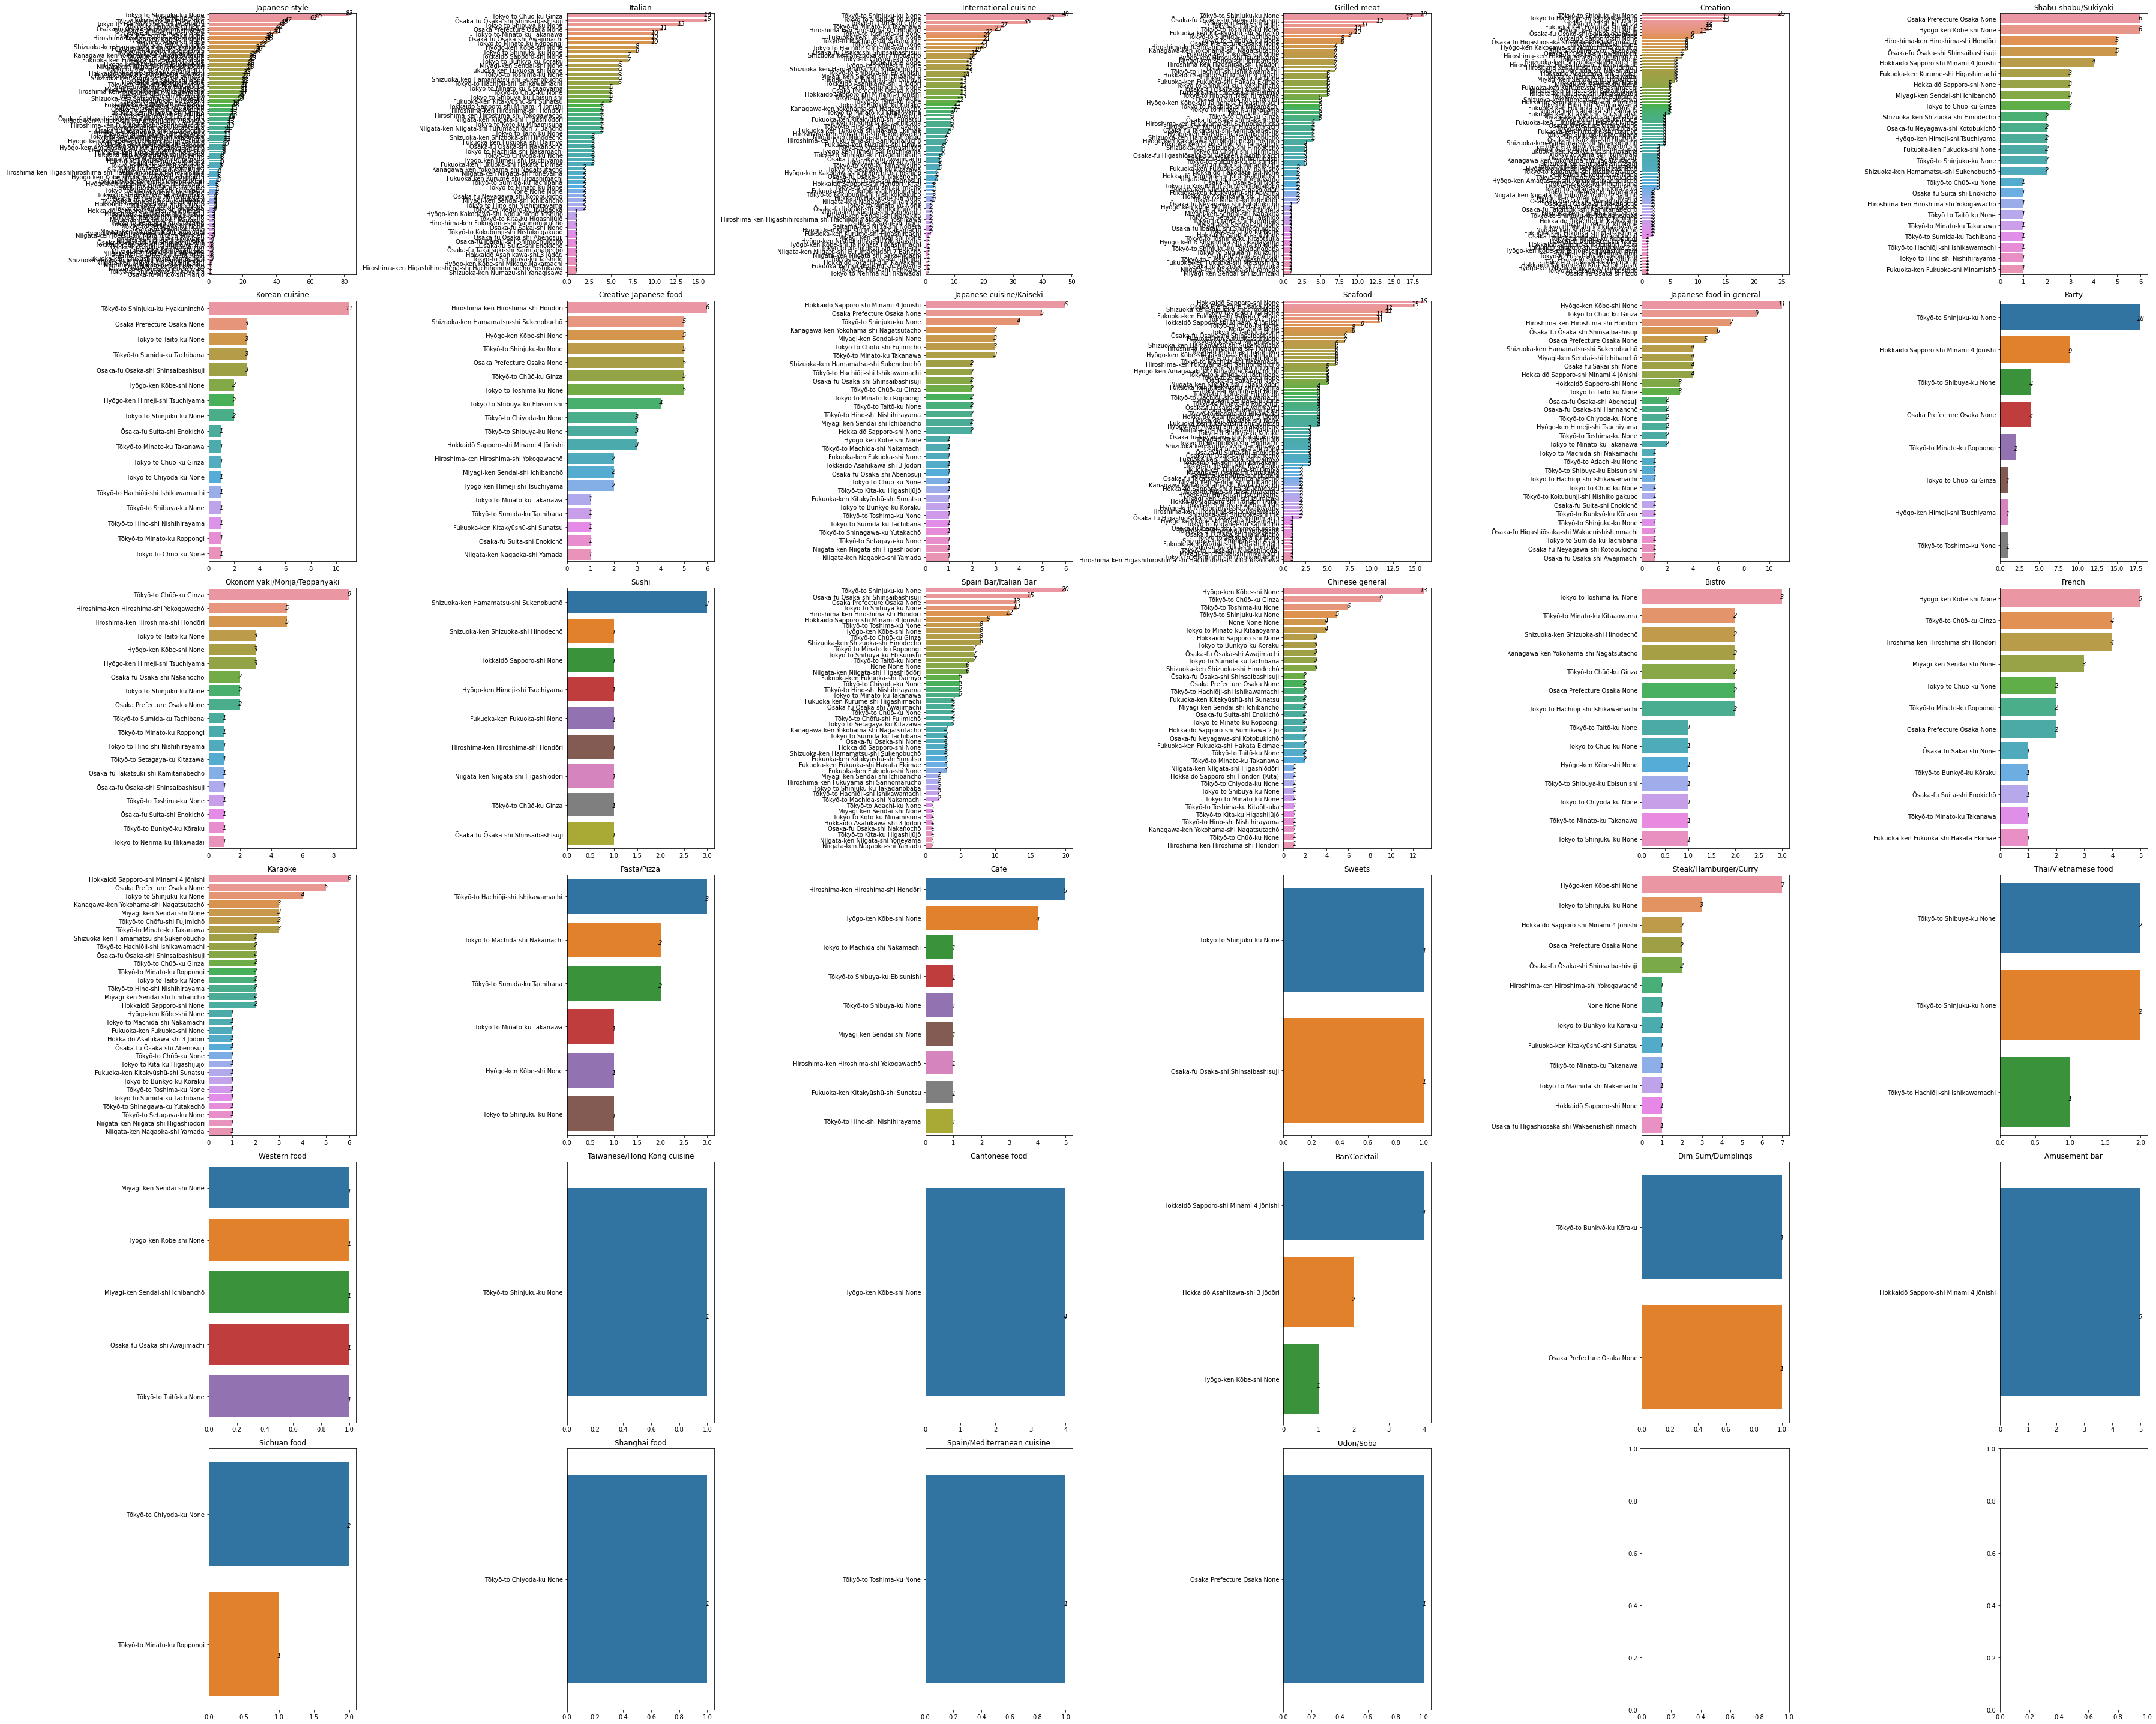

In [458]:
count_list = [hpg_JS_count, hpg_IT_count, hpg_IC_count, hpg_GM_count, hpg_CR_count, hpg_SH_count, hpg_KC_count, 
              hpg_CJ_count, hpg_KA_count, hpg_SE_count, hpg_JG_count, hpg_PA_count, hpg_YA_count, hpg_SU_count,
              hpg_SI_count, hpg_CG_count, hpg_BI_count, hpg_FR_count, hpg_KA_count, hpg_PP_count, hpg_AS_count,
              hpg_CA_count, hpg_SHG_count, hpg_TV_count, hpg_WE_count, hpg_TH_count, hpg_CF_count, hpg_BC_count,
              hpg_DD_count, hpg_AB_count, hpg_SF_count, hpg_SHF_count, hpg_SM_count, hpg_US_count]

name_list = hpg_store_info["hpg_genre_name"].unique()

fig, axes = plt.subplots(figsize=(50, 40), nrows=6, ncols=6)
axs = axes.ravel()
for i, ax in enumerate(axs):
    if i >= len(count_list): continue
    sns.barplot(y=count_list[i].index, x=count_list[i].values, ax=ax)
    ax.set_title(f"{name_list[i]}")
    for p in ax.patches:
        left, bottom, width, height = p.get_bbox().bounds
        ax.annotate(int(width), (width, bottom+0.5), ha = 'center', color = 'k', style='italic')

fig.tight_layout()

데이터도 많고 종류도 너무 많다보니 실제적으로 상당히 보기가 어렵습니다. 전체적인 갯수와 분포를 살펴보는 정도로 참고하는 게 좋을 것 같습니다. 몇개의 데이터는 한 매장만 있는 경우도 많으니 적당히 카테고리를 합쳐주는 방향도 생각해봐야 할 것 같습니다.

In [459]:
hpg_genre = pd.pivot_table(hpg_store_info, index='hpg_area_name', columns='hpg_genre_name', aggfunc='size').fillna(0).astype(np.int8)

In [460]:
hpg_genre.head()

hpg_genre_name                         Amusement bar  ...  Western food
hpg_area_name                                         ...              
Fukuoka-ken Chikushino-shi Yamaguchi               0  ...             0
Fukuoka-ken Fukuoka-shi Daimyō                     0  ...             0
Fukuoka-ken Fukuoka-shi Hakata Ekimae              0  ...             0
Fukuoka-ken Fukuoka-shi Matsushima                 0  ...             0
Fukuoka-ken Fukuoka-shi Minamishō                  0  ...             0

[5 rows x 34 columns]

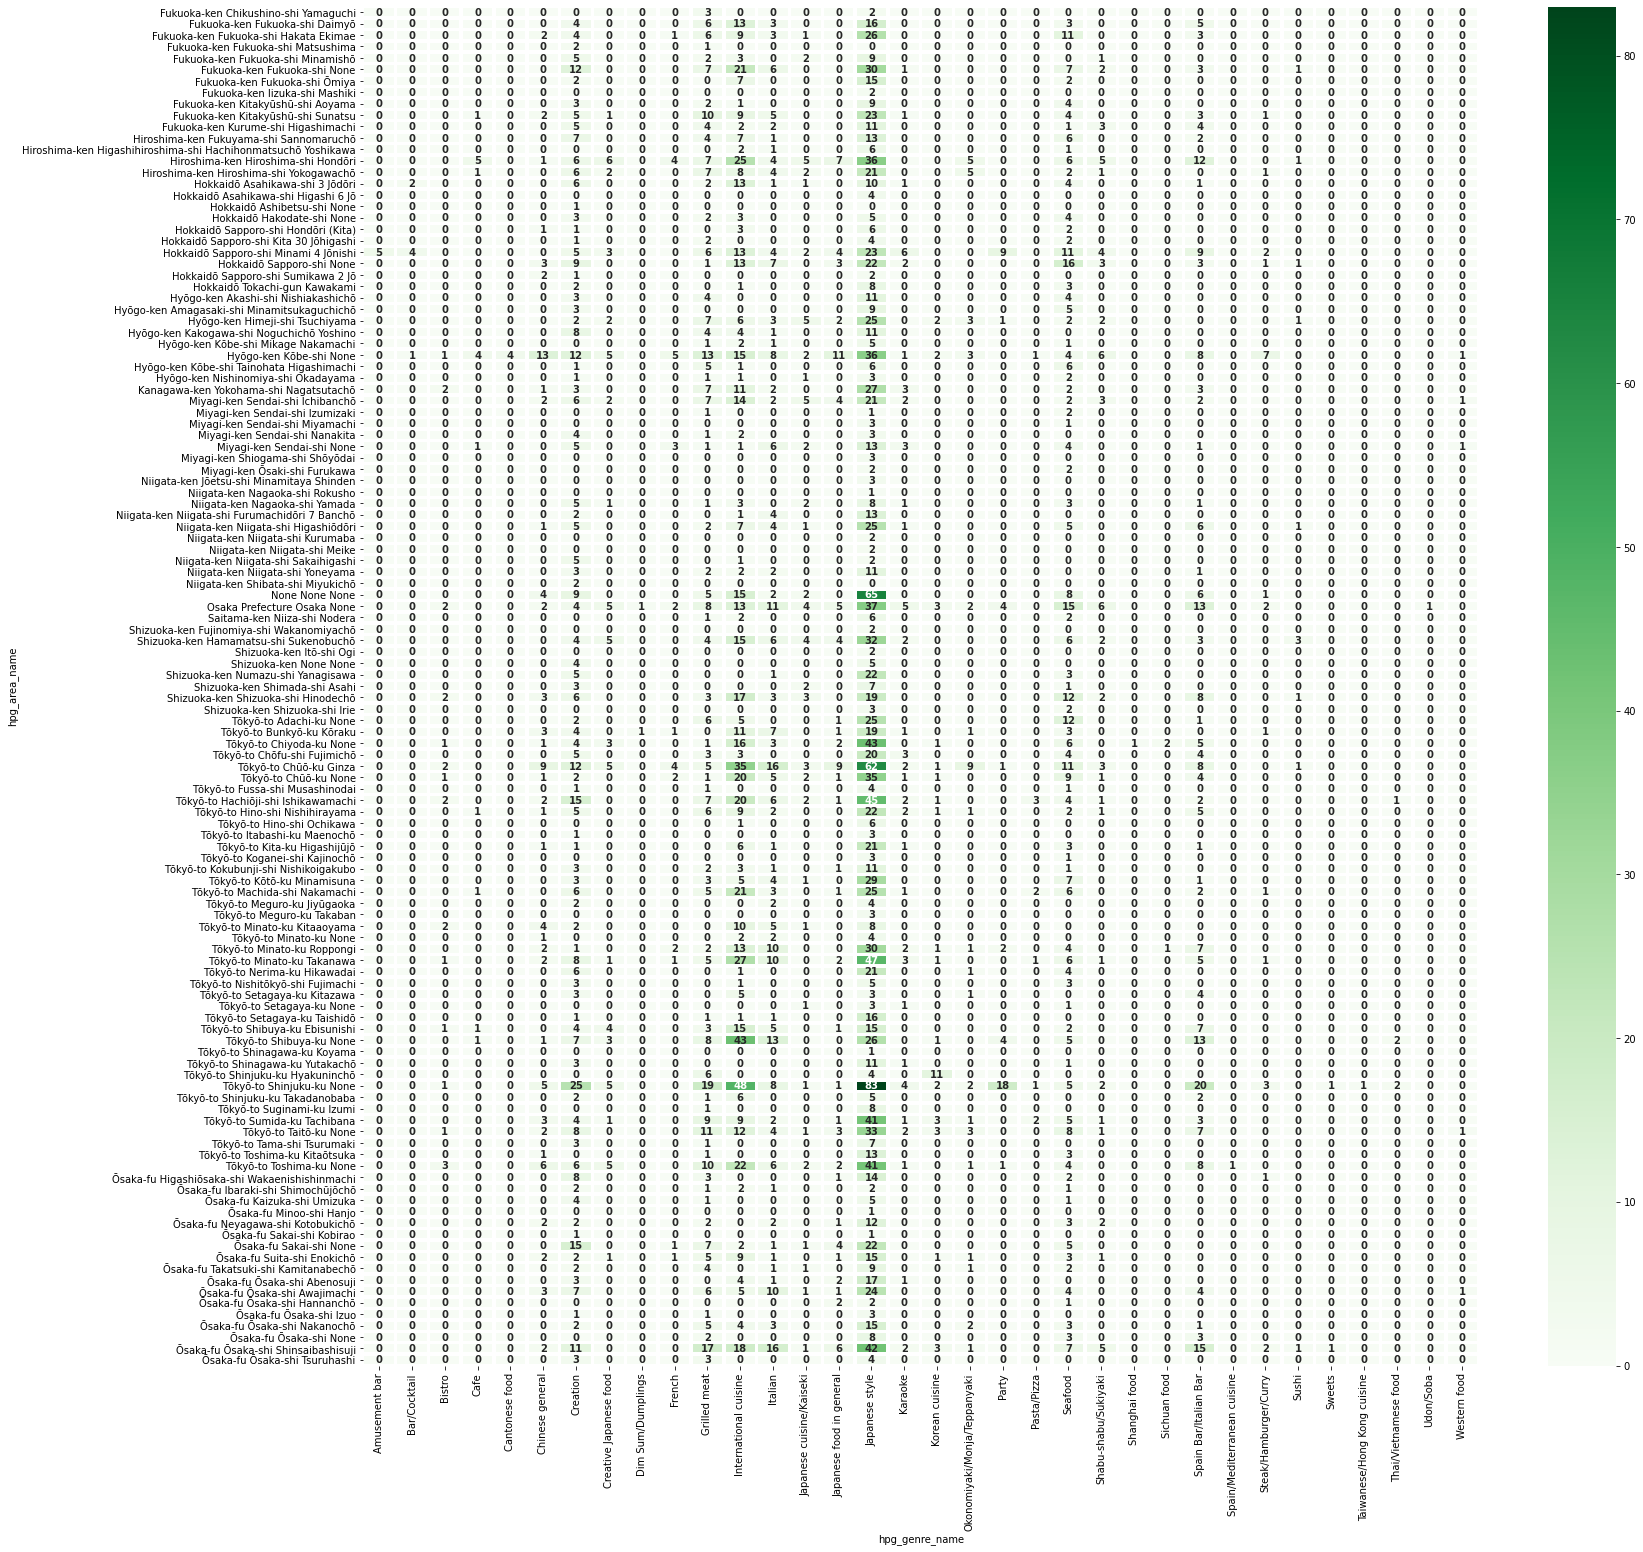

In [461]:
fig, ax = plt.subplots(figsize=(25, 25))
sns.heatmap(hpg_genre, ax=ax, linewidths=2.5, annot=True, annot_kws={"size": 10, "fontweight": 'bold'}, cmap="Greens", fmt="d")

hpg도 heatmap을 통해 각 지역별로 어떤 종류의 음식을 파는 매장이 많이 놓여있는 지 볼 수 있습니다. 반대로 음식 종류의 지역적인 분포를 알고 싶다면 데이터프레임의 전치(transpose)를 이용하면 좀 더 쉽게 볼 수 있습니다.

In [462]:
len(sample_submission)

32019

### 2-5 Analysis of `air_visit_data`

air 플랫폼에 등록된 가게에 실제로 방문한 방문자수에 대해 EDA를 해보겠습니다.

In [463]:
air_visit_data.head()

air_store_id  visit_date  visitors
0  air_ba937bf13d40fb24  2016-01-13        25
1  air_ba937bf13d40fb24  2016-01-14        32
2  air_ba937bf13d40fb24  2016-01-15        29
3  air_ba937bf13d40fb24  2016-01-16        22
4  air_ba937bf13d40fb24  2016-01-18         6

In [464]:
air_visit_data.describe()

visitors
count  252108.000000
mean       20.973761
std        16.757007
min         1.000000
25%         9.000000
50%        17.000000
75%        29.000000
max       877.000000

In [465]:
air_visit_data.isnull().sum()

air_store_id    0
visit_date      0
visitors        0
dtype: int64

우선 위에서 했던 것처럼 `visit_date`를 datetime 형식으로 바꿔주겠습니다.

In [466]:
air_visit_data['visit_date'] = pd.to_datetime(air_visit_data['visit_date'])

In [467]:
air_visit_data_day = air_visit_data['visit_date'].dt.day_name()
air_visit_data_month = air_visit_data['visit_date'].dt.month_name()

air_visit_data["visit_date_day"] = air_visit_data_day
air_visit_data["visit_date_month"] = air_visit_data_month

air_visit_data.head()

air_store_id visit_date  visitors visit_date_day visit_date_month
0  air_ba937bf13d40fb24 2016-01-13        25      Wednesday          January
1  air_ba937bf13d40fb24 2016-01-14        32       Thursday          January
2  air_ba937bf13d40fb24 2016-01-15        29         Friday          January
3  air_ba937bf13d40fb24 2016-01-16        22       Saturday          January
4  air_ba937bf13d40fb24 2016-01-18         6         Monday          January

In [468]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

day_visitor_count = pd.pivot_table(air_visit_data, index='visit_date_day', values='visitors', aggfunc='sum').reindex(days).reset_index()
month_visitor_count = pd.pivot_table(air_visit_data, index='visit_date_month', values='visitors', aggfunc='sum').reindex(months).reset_index()

In [469]:
display(day_visitor_count)
display(month_visitor_count)

visit_date_day  visitors
0         Monday    544202
1        Tuesday    636462
2      Wednesday    707880
3       Thursday    718987
4         Friday    931008
5       Saturday   1033128
6         Sunday    715986

visit_date_month  visitors
0           January    539772
1          February    561396
2             March    684779
3             April    520508
4               May    179618
5              June    175822
6              July    455702
7            August    408300
8         September    414673
9           October    436183
10         November    413283
11         December    497617

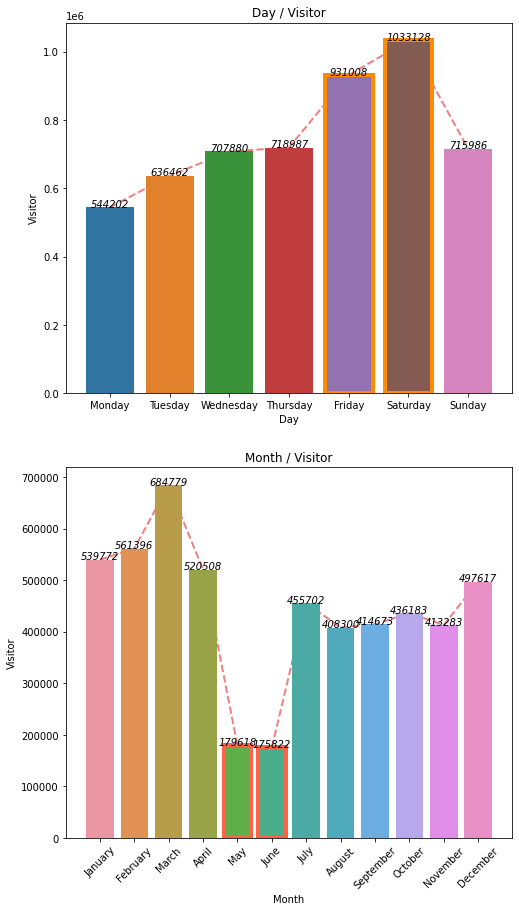

In [470]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 15))
axs = axes.ravel()
sns.barplot(data=day_visitor_count, x="visit_date_day", y="visitors", ax=axs[0], zorder=2)
sns.lineplot(data=day_visitor_count, x="visit_date_day", y="visitors", ax=axs[0], zorder=1, 
             linewidth=2, linestyle='--', color='lightcoral')
axs[0].set_title("Day / Visitor")
axs[0].set_ylabel("Visitor")
axs[0].set_xlabel("Day")
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')

axs[0].patches[4].set_linewidth('4')
axs[0].patches[4].set_edgecolor('darkorange')
axs[0].patches[5].set_linewidth('4')
axs[0].patches[5].set_edgecolor('darkorange')

sns.barplot(data=month_visitor_count, x="visit_date_month", y="visitors", ax=axs[1], zorder=2)
sns.lineplot(data=month_visitor_count, x="visit_date_month", y="visitors", ax=axs[1], zorder=1,
             linewidth=2, linestyle='--', color='lightcoral')
axs[1].set_title("Month / Visitor")
axs[1].set_ylabel("Visitor")
axs[1].set_xlabel("Month")
x_tick_labels = [t.get_text() for t in axs[1].get_xticklabels()]
axs[1].set_xticklabels(x_tick_labels, rotation=45)
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height), ha = 'center', color = 'k', style='italic')  

axs[1].patches[4].set_linewidth('4')
axs[1].patches[4].set_edgecolor('tomato')
axs[1].patches[5].set_linewidth('4')
axs[1].patches[5].set_edgecolor('tomato')  

위에서 살펴본 것과 비슷하게 실제 방문자 또한 금요일, 토요일에 많이 있음을 알 수 있습니다. 또한 데이터 구성에 있어서 2017년 4월을 기준으로 나뉘기 때문에 5, 6월에 해당하는 데이터가 적은 것으로 생각이 듭니다. (추가 파악 필요)

### 2-6 Analysis of the rest
`store_id_relation`, `date_info`, `sample_submission` 에 대한 간단한 분석을 해보겠습니다. `store_id_relation`, `date_info` 데이터는 실제 아주 중요한 특성값을 보유하기 보다는 데이터 분석에 도움이 되는 정보들을 담고 있습니다. 따라서 어떤 모습을 보이고 있는지 어떻게 활용할 수 있는지에 초점을 두고 살펴보겠습니다.

`sample_submission`을 통해서는 개략적인 제출해야 되는 형식을 보면서 어떤식으로 데이터를 구성해야하는지 알아보겠습니다.

In [471]:
store_id_relation.head()

air_store_id          hpg_store_id
0  air_63b13c56b7201bd9  hpg_4bc649e72e2a239a
1  air_a24bf50c3e90d583  hpg_c34b496d0305a809
2  air_c7f78b4f3cba33ff  hpg_cd8ae0d9bbd58ff9
3  air_947eb2cae4f3e8f2  hpg_de24ea49dc25d6b8
4  air_965b2e0cf4119003  hpg_653238a84804d8e7

store_id_relation은 air와 hpg 둘다 사용하는 매장에 한해서 어떤 id를 각각 가지는 지 보여주고 있습니다. 테스트 셋에서는 air에 대한 데이터만 가지고 있으므로 이에 맞게 둘다 포함되는 hpg만 air_id로 바꿔 데이터 셋을 구성하는 방향으로 생각하면 될 것 같습니다.

In [472]:
date_info.head()

calendar_date day_of_week  holiday_flg
0    2016-01-01      Friday            1
1    2016-01-02    Saturday            1
2    2016-01-03      Sunday            1
3    2016-01-04      Monday            0
4    2016-01-05     Tuesday            0

date_info는 해당하는 날짜가 무슨 요일이고 공휴일인지 표기를 해주고 있습니다. 요일에 관해서는 pandas의 메소드로 처리를 했으므로 공휴일 유무를 데이터에 추가하는 방향으로 활용할 수 있을 것 같습니다.

In [473]:
sample_submission.head()

id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0
3  air_00a91d42b08b08d9_2017-04-26         0
4  air_00a91d42b08b08d9_2017-04-27         0

캐글 대회에 파일을 제출할 때 어떤식으로 구성되어야 하는지에 대해 보여주고 있습니다.

In [474]:
test = sample_submission.copy()
test.head()

id  visitors
0  air_00a91d42b08b08d9_2017-04-23         0
1  air_00a91d42b08b08d9_2017-04-24         0
2  air_00a91d42b08b08d9_2017-04-25         0
3  air_00a91d42b08b08d9_2017-04-26         0
4  air_00a91d42b08b08d9_2017-04-27         0

[Reference](https://github.com/junaidnasirkhan/Restaurant-Visitor-Forecasting)

데이터를 준비하는 과정에서 merge의 on등을 이용해 겹치는 부분에 한해 쉽게 붙일 수 있는 점이 인상적이여서 많은 참고를 하게 되었습니다.

테스트 셋이 air로만 이루어져있기 때문에, air에 관한 정보를 찾아서 빼내주어야 한다는 인사이트를 늦게 얻어 많이 헤맸습니다. 그 과정에서 많은 도움이 됐습니다. 

가장 많이 참고한 부분은 데이터를 준비하는 과정에서 air_data를 만드는 부분이였으며 기타 total_reserve_data 또는 이를 이용해 다양한 피쳐를 추가해주는 부분은 최대한 해커톤 조 내에서 하려고 노력했습니다.


## 학습용 데이터 준비

*(별도의 노트북에서 진행해 아래에 모듈 및 데이터를 다운로드 받는 부분이 다시 구현되있습니다.)*

### Kaggle에서 데이터 다운로드 받기

In [475]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (4).json


{'kaggle.json': b'{"username":"sunnwoongchoi","key":"00037850b93dbb9f6c5993595ede0f49"}'}

In [476]:
ls -1ha kaggle.json

kaggle.json


In [477]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json
# 본인이 참가한 모든 대회 보기 
!kaggle competitions list

ref                                                  deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
contradictory-my-dear-watson                         2030-07-01 23:59:00  Getting Started     Prizes        241           False  
gan-getting-started                                  2030-07-01 23:59:00  Getting Started     Prizes        414           False  
tpu-getting-started                                  2030-06-03 23:59:00  Getting Started  Knowledge       1073           False  
digit-recognizer                                     2030-01-01 00:00:00  Getting Started  Knowledge       6994           False  
titanic                                              2030-01-01 00:00:00  Getting Started  Knowledge      88047            True  
house-prices-advanced-regression-techniques          2030-01-01 00:00:00  Getting Started 

In [478]:
!kaggle competitions download -c recruit-restaurant-visitor-forecasting

air_reserve.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
store_id_relation.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
date_info.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
hpg_store_info.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
hpg_reserve.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
air_visit_data.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
air_store_info.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [479]:
air_reserve = pd.read_csv("air_reserve.csv.zip")
hpg_reserve = pd.read_csv("hpg_reserve.csv.zip")
air_store_info = pd.read_csv("air_store_info.csv.zip")
hpg_store_info = pd.read_csv("hpg_store_info.csv.zip")
air_visit_data = pd.read_csv("air_visit_data.csv.zip")  
store_id_relation = pd.read_csv("store_id_relation.csv.zip")
date_info = pd.read_csv("date_info.csv.zip")
sample_submission = pd.read_csv("sample_submission.csv.zip")

### air_data

`air_data`를 만드는 과정입니다.
1. `air_visit_data`에 `air_store_info`를 합칩니다. 이 때 `air_store_id`를 기준으로 하며, `air_visit_data`에 있는 고유값들을 기준으로 합쳐줍니다.
2. `date_info`에 해당하는 값을 합쳐줍니다.
3. `visit_date` 기준으로 정렬을 하고, date에서 뽑아낼 수 있는 날짜에 대한 정보를 활용해 `air_data`를 가공해줍니다.

In [480]:
air_data = pd.merge(air_visit_data, air_store_info, how='left', on=['air_store_id']) # merging dataframes
date_info.rename(columns={'calendar_date':'visit_date'},inplace=True)  # renaming columns
air_data = pd.merge(air_data,date_info,how='left', on=['visit_date'])
air_data.sort_values(by='visit_date',ignore_index=True,inplace=True)
air_data['visit_date'] = pd.to_datetime(air_data['visit_date'])
air_data['day'] = air_data['visit_date'].dt.day
air_data['dow'] = air_data['visit_date'].dt.isocalendar().week ## weekday -> weekofyear
air_data['year'] = air_data['visit_date'].dt.year
air_data['month'] = air_data['visit_date'].dt.month
air_data['week'] = air_data['visit_date'].dt.isocalendar().week
air_data['quarter'] = air_data['visit_date'].dt.quarter
air_data['visit_date'] = air_data['visit_date'].dt.date
air_data.to_csv('air_data.csv',index=False)

`air_reserve_data`를 만드는 과정입니다.
1. `air_reserve`에 `air_store_info`를 합칩니다. 이 때 `air_store_id`를 기준으로 하며, `air_visit_data`에 있는 고유값들을 기준으로 합쳐줍니다.

2. date에서 뽑아낼 수 있는 날짜에 대한 정보를 활용해 `air_data`를 가공해줍니다.
3. 추가적으로 방문예정시각과 예약시각의 차이를 `res_vis_diff` 라는 컬럼에 입력해줍니다.

In [481]:
# preprocessing AIR reservation data
air_reserve_data = pd.merge(air_reserve, air_store_info, how='left', on=['air_store_id'])
air_reserve_data.head()
air_reserve_data['visit_datetime'] = pd.to_datetime(air_reserve_data['visit_datetime'])
air_reserve_data['visit_hour'] = air_reserve_data['visit_datetime'].dt.hour
air_reserve_data['visit_date'] = air_reserve_data['visit_datetime'].dt.date
air_reserve_data['reserve_datetime'] = pd.to_datetime(air_reserve_data['reserve_datetime'])
air_reserve_data['reserve_hour'] = air_reserve_data['reserve_datetime'].dt.hour
air_reserve_data['reserve_date'] = air_reserve_data['reserve_datetime'].dt.date
#calculate reservation time difference 
air_reserve_data['res_vis_diff'] = air_reserve_data.apply(
        lambda d: (d['visit_date'] - d['reserve_date']).days, axis=1)
air_reserve_data.rename(columns={'reserve_visitors':'air_reserve_visitors'},inplace=True)
air_reserve_data.to_csv('air_reserve_data.csv',index=False)

### hpg_reserve_data

`hpg_reserve_data`를 만드는 과정입니다.
1. `hpg_reserve`에 `store_id_relation`를 합칩니다. 이 때 `hpg_store_id`를 기준으로 합쳐줍니다. 이런 방식을 통해 `store_id_relation`과 동시에 `hpg_reserve`에 존재하는 식당을 대상으로 merge를 하게 됩니다. _(`how=inner` 를 사용)_

`air_data`와 비슷한 과정을 반복합니다.

In [482]:
hpg_reserve_data = pd.merge(hpg_reserve,store_id_relation,on=['hpg_store_id'],how='inner')
hpg_reserve_data = pd.merge(hpg_reserve_data,hpg_store_info,on=['hpg_store_id'],how='left')
hpg_reserve_data['visit_datetime'] = pd.to_datetime(hpg_reserve_data['visit_datetime'])
hpg_reserve_data['visit_hour'] = hpg_reserve_data['visit_datetime'].dt.hour
hpg_reserve_data['visit_date'] = hpg_reserve_data['visit_datetime'].dt.date
hpg_reserve_data['reserve_datetime'] = pd.to_datetime(hpg_reserve_data['reserve_datetime'])
hpg_reserve_data['reserve_hour'] = hpg_reserve_data['reserve_datetime'].dt.hour
hpg_reserve_data['reserve_date'] = hpg_reserve_data['reserve_datetime'].dt.date
#calculate reserve time difference 
hpg_reserve_data['res_vis_diff'] = hpg_reserve_data.apply(
        lambda r: (r['visit_date'] - r['reserve_date']).days, axis=1)
hpg_reserve_data.rename(columns={'reserve_visitors':'hpg_reserve_visitors'},inplace=True)

hpg_reserve_data.to_csv('hpg_reserve_data.csv',index=False)


In [483]:
hpg_reserve_data.head()

hpg_store_id      visit_datetime  ... reserve_date  res_vis_diff
0  hpg_878cc70b1abc76f7 2016-01-01 19:00:00  ...   2016-01-01             0
1  hpg_878cc70b1abc76f7 2016-01-02 19:00:00  ...   2016-01-02             0
2  hpg_878cc70b1abc76f7 2016-01-03 18:00:00  ...   2016-01-02             1
3  hpg_878cc70b1abc76f7 2016-01-06 20:00:00  ...   2016-01-04             2
4  hpg_878cc70b1abc76f7 2016-01-11 18:00:00  ...   2016-01-11             0

[5 rows x 14 columns]

In [484]:
hpg_reserve_data = hpg_reserve_data.drop(columns='hpg_store_id', axis=1)
hpg_reserve_data = pd.merge(hpg_reserve_data, air_store_info, on='air_store_id', how='left')
hpg_reserve_data['air_store_id'].replace('(.*)air_(.*)', r'\1both_\2', regex=True, inplace=True) ## 둘다 포함됐음을 명시

hpg_reserve_data.head()

visit_datetime    reserve_datetime  ...  latitude_y longitude_y
0 2016-01-01 19:00:00 2016-01-01 15:00:00  ...   43.770635  142.364819
1 2016-01-02 19:00:00 2016-01-02 14:00:00  ...   43.770635  142.364819
2 2016-01-03 18:00:00 2016-01-02 20:00:00  ...   43.770635  142.364819
3 2016-01-06 20:00:00 2016-01-04 22:00:00  ...   43.770635  142.364819
4 2016-01-11 18:00:00 2016-01-11 14:00:00  ...   43.770635  142.364819

[5 rows x 17 columns]

### total_reserve_data

전체 예약정보를 볼 수 있는 total_reserve_data 를 만드는 과정입니다. concat을 통해 합치면서 발생하는 NaN값들은 모두 수치형데이터 또는 범주형 데이터이므로 0으로 처리를 해줬습니다.

또한 위도, 경도 정보가 들어오면서 각각 다른 열로 분류되며 일부가 결측치로 나오는 경우가 있어서 해당하는 값으로 채워줬습니다.

장르네임 같은 경우, hpg에서 결측인 부분이 있어 해당 부분은 air의 장르로 채워줬습니다. 이후 필요없는 열을 버리면서 데이터프레임을 완성합니다.

In [485]:
total_reserve_data = pd.concat([air_reserve_data, hpg_reserve_data])

total_reserve_data['air_reserve_visitors'].fillna(0, inplace=True)

total_reserve_data['latitude'].fillna(total_reserve_data['latitude_x'], inplace=True)
total_reserve_data['latitude'].fillna(total_reserve_data['latitude_y'], inplace=True)
total_reserve_data['longitude'].fillna(total_reserve_data['longitude_x'], inplace=True)
total_reserve_data['longitude'].fillna(total_reserve_data['longitude_y'], inplace=True)

total_reserve_data['hpg_reserve_visitors'].fillna(0, inplace=True)

total_reserve_data['hpg_genre_name'].fillna(total_reserve_data["air_genre_name"], inplace=True)
total_reserve_data.drop(columns=['hpg_area_name', "latitude_x", "longitude_x", "latitude_y", "longitude_y"], axis=1, inplace=True)

total_reserve_data['both-contained'] = np.where(total_reserve_data['air_store_id'].str.contains('both'), 1, 0) ## 이름을 바꿔주면서 Flag로 사용.
total_reserve_data['air_store_id'].replace('(.*)both_(.*)', r'\1air_\2', regex=True, inplace=True)

total_reserve_data.drop(columns='air_genre_name', axis=1, inplace=True) ## hpg_genre_name에 포함되어있다.
total_reserve_data.drop(columns=['visit_datetime', 'reserve_datetime'], axis=1, inplace=True)

In [486]:
print('HEAD')
display(total_reserve_data.head())
print('TAIL')
display(total_reserve_data.tail())

HEAD


air_store_id  air_reserve_visitors  ... hpg_genre_name  both-contained
0  air_877f79706adbfb06                   1.0  ...  Japanese food               0
1  air_db4b38ebe7a7ceff                   3.0  ...     Dining bar               0
2  air_db4b38ebe7a7ceff                   6.0  ...     Dining bar               0
3  air_877f79706adbfb06                   2.0  ...  Japanese food               0
4  air_db80363d35f10926                   5.0  ...     Dining bar               0

[5 rows x 13 columns]

TAIL


air_store_id  ...  both-contained
28178  air_84f6876ff7e83ae7  ...               1
28179  air_84f6876ff7e83ae7  ...               1
28180  air_84f6876ff7e83ae7  ...               1
28181  air_84f6876ff7e83ae7  ...               1
28182  air_84f6876ff7e83ae7  ...               1

[5 rows x 13 columns]

air_data에 넣어줄 각 플랫폼 별 전체 예약수를 넣어주고 있습니다.

In [487]:
total_air_reserve = total_reserve_data.groupby(['air_store_id','visit_date'],as_index=False)['air_reserve_visitors'].sum()
total_hpg_reserve =  total_reserve_data.groupby(['air_store_id','visit_date'],as_index=False)['hpg_reserve_visitors'].sum()

In [488]:
air_data = pd.merge(air_data,total_air_reserve,on=['air_store_id','visit_date'],how='left')
air_data = pd.merge(air_data,total_hpg_reserve,on=['air_store_id','visit_date'],how='left')

air_data.shape

(252108, 17)

In [489]:
air_data.fillna(0, inplace=True)

In [490]:
air_data.head()

air_store_id  visit_date  ...  air_reserve_visitors hpg_reserve_visitors
0  air_fab092c35776a9b1  2016-01-01  ...                   0.0                  0.0
1  air_f26f36ec4dc5adb0  2016-01-01  ...                   0.0                  0.0
2  air_d97dabf7aae60da5  2016-01-01  ...                   0.0                  0.0
3  air_39dccf7df20b1c6a  2016-01-01  ...                   0.0                  0.0
4  air_79f528087f49df06  2016-01-01  ...                   0.0                  0.0

[5 rows x 17 columns]

In [491]:
air_data.to_csv('air_data.csv', index=False)

In [492]:
from google.colab import files
files.download("air_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### EDA of air_data

air_data에 대한 분석을 간단하게 진행해보겠습니다.

In [493]:
air_data.head()

air_store_id  visit_date  ...  air_reserve_visitors hpg_reserve_visitors
0  air_fab092c35776a9b1  2016-01-01  ...                   0.0                  0.0
1  air_f26f36ec4dc5adb0  2016-01-01  ...                   0.0                  0.0
2  air_d97dabf7aae60da5  2016-01-01  ...                   0.0                  0.0
3  air_39dccf7df20b1c6a  2016-01-01  ...                   0.0                  0.0
4  air_79f528087f49df06  2016-01-01  ...                   0.0                  0.0

[5 rows x 17 columns]

In [494]:
genre_visitors = pd.pivot_table(air_data, index='air_genre_name', values='visitors', aggfunc='sum').reset_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_visitors = pd.pivot_table(air_data, index='day_of_week', values='visitors', aggfunc='sum').reindex(days).reset_index()

In [495]:
day_visitors

day_of_week  visitors
0      Monday    544202
1     Tuesday    636462
2   Wednesday    707880
3    Thursday    718987
4      Friday    931008
5    Saturday   1033128
6      Sunday    715986

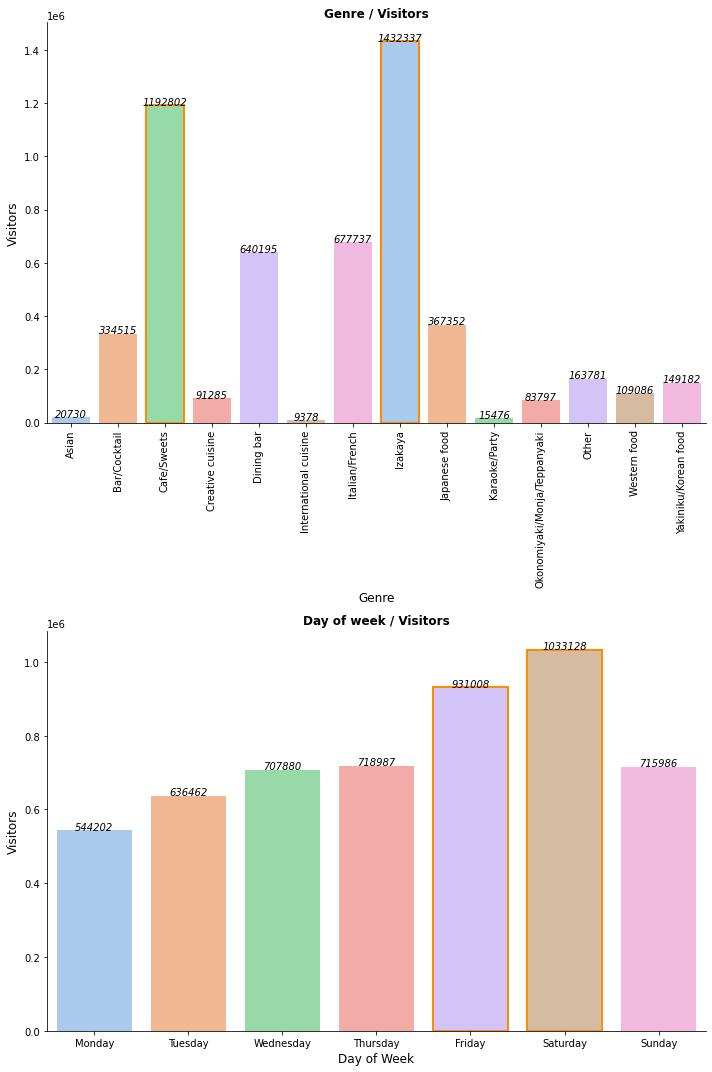

In [496]:
colors = sns.color_palette("pastel", 7)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 15))
axs = axes.ravel()
sns.barplot(data=genre_visitors, x="air_genre_name", y="visitors", ax=axs[0], palette=colors)

axs[0].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[0].set_xlabel("Genre", fontsize=12, fontweight='light')

axs[0].set_title("Genre / Visitors", fontweight='bold')
for p in axs[0].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[0].annotate(int(height), (left+width/2, height+1000), ha = 'center', color = 'k', style='italic')

x_tick_labels = [t.get_text() for t in axs[0].get_xticklabels()]
axs[0].set_xticklabels(x_tick_labels, rotation=90)

axs[0].patches[7].set_linewidth('2')
axs[0].patches[7].set_edgecolor('darkorange')

axs[0].patches[2].set_linewidth('2')
axs[0].patches[2].set_edgecolor('darkorange')



axs[0].spines['top'].set_visible(False)
axs[0].spines['right'].set_visible(False)

sns.barplot(data=day_visitors, x="day_of_week", y="visitors", ax=axs[1], palette=colors)

axs[1].set_ylabel("Visitors", fontsize=12, fontweight='light')
axs[1].set_xlabel("Day of Week", fontsize=12, fontweight='light')

axs[1].set_title("Day of week / Visitors", fontweight='bold')
for p in axs[1].patches:
    left, bottom, width, height = p.get_bbox().bounds
    axs[1].annotate(int(height), (left+width/2, height+1000), ha = 'center', color = 'k', style='italic')

axs[1].patches[4].set_linewidth('2')
axs[1].patches[4].set_edgecolor('darkorange')
axs[1].patches[5].set_linewidth('2')
axs[1].patches[5].set_edgecolor('darkorange')

axs[1].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)

fig.tight_layout()

요일은 예약과 비슷하게 금, 토요일에 가장 방문객이 많습니다. 예약이 많은 만큼 방문객도 많다고 생각할 수 있을 것 같습니다. 음식 종류의 경우 이자카야가 가장 많고 그 뒤로는 카페가 있습니다.

### Training set
위에서 만든 air_data를 train_set으로 사용할 수 있습니다. 따라서 복사를 해주고 필요에 따라 컬럼을 없애서 중복되는 feature가 없게 분류해주고 있습니다.

또한 각 feature별 특성에 따라 범주형 데이터가 되야하는 경우, 라벨링을 하는 전처리를 진행하겠습니다.

In [497]:
train_set = air_data.copy()

In [498]:
train_set.head()

air_store_id  visit_date  ...  air_reserve_visitors hpg_reserve_visitors
0  air_fab092c35776a9b1  2016-01-01  ...                   0.0                  0.0
1  air_f26f36ec4dc5adb0  2016-01-01  ...                   0.0                  0.0
2  air_d97dabf7aae60da5  2016-01-01  ...                   0.0                  0.0
3  air_39dccf7df20b1c6a  2016-01-01  ...                   0.0                  0.0
4  air_79f528087f49df06  2016-01-01  ...                   0.0                  0.0

[5 rows x 17 columns]

In [499]:
print("Training data duration:{} to {}".format(train_set.visit_date.min(), train_set.visit_date.max()))

Training data duration:2016-01-01 to 2017-04-22


In [500]:
train_set.drop(columns=["visit_date"], axis=1, inplace=True) ## 이미 정보가 저장되어 있으므로

In [501]:
## 범주형 데이터가 되야하는 부분 ##
train_set['air_store_id'] = train_set['air_store_id'].astype('category').cat.codes ## 이거 주의
train_set['day_of_week'] = train_set['day_of_week'].astype('category').cat.codes
train_set['air_genre_name'] = train_set['air_genre_name'].astype('category').cat.codes
train_set['air_area_name'] = train_set['air_area_name'].astype('category').cat.codes
train_set['day_of_week'] = train_set['day_of_week'].astype('category').cat.codes
train_set['year'] = train_set['year'].astype('category').cat.codes
train_set['month'] = train_set['month'].astype('category').cat.codes
train_set['week'] = train_set['week'].astype('category').cat.codes
train_set['quarter'] = train_set['quarter'].astype('category').cat.codes

In [502]:
train_set.head()

air_store_id  visitors  ...  air_reserve_visitors  hpg_reserve_visitors
0           812        19  ...                   0.0                   0.0
1           791        64  ...                   0.0                   0.0
2           705       102  ...                   0.0                   0.0
3           173        55  ...                   0.0                   0.0
4           383        42  ...                   0.0                   0.0

[5 rows x 16 columns]

In [503]:
train_set.shape

(252108, 16)

### Submission

`sample_submission` 데이터는 추후에 test_data로 활용할 예정입니다. 따라서 테스트 셋으로 사용 될 것을 염두에 두고 미리 전처리를 해주겠습니다. 기본적으로는 위의 과정을 다시 한번 반복해서 적용시켜 주고 있습니다.

In [504]:
sample_submission = pd.read_csv("sample_submission.csv.zip")

In [505]:
sample_submission['air_store_id'] = sample_submission['id'].map(lambda x: '_'.join(x.split('_')[:2]))
sample_submission['visit_date'] = sample_submission['id'].map(lambda x: str(x).split('_')[2])

sample_submission = pd.merge(sample_submission, date_info, how='left', on=['visit_date'])

sample_submission['visit_date'] = pd.to_datetime(sample_submission['visit_date'])
sample_submission['day'] = sample_submission['visit_date'].dt.day
sample_submission['dow'] = sample_submission['visit_date'].dt.weekday
sample_submission['dow_name'] = sample_submission['visit_date'].dt.day_name()
sample_submission['year'] = sample_submission['visit_date'].dt.year
sample_submission['month'] = sample_submission['visit_date'].dt.month
sample_submission['week'] = sample_submission['visit_date'].dt.isocalendar().week
sample_submission['quarter'] = sample_submission['visit_date'].dt.quarter
sample_submission['visit_date'] = sample_submission['visit_date'].dt.date

sample_submission.to_csv('sample_submission.csv',index=False)

sample_submission.shape

(32019, 13)

In [506]:
sample_submission.drop(columns='id', axis=1, inplace=True)

In [507]:
sample_submission.head()

visitors          air_store_id  visit_date  ... month  week  quarter
0         0  air_00a91d42b08b08d9  2017-04-23  ...     4    16        2
1         0  air_00a91d42b08b08d9  2017-04-24  ...     4    17        2
2         0  air_00a91d42b08b08d9  2017-04-25  ...     4    17        2
3         0  air_00a91d42b08b08d9  2017-04-26  ...     4    17        2
4         0  air_00a91d42b08b08d9  2017-04-27  ...     4    17        2

[5 rows x 12 columns]

In [508]:
sample_submission = pd.merge(sample_submission, air_store_info, how='left', on=['air_store_id'])
sample_submission = pd.merge(sample_submission,total_air_reserve,on=['air_store_id','visit_date'],how='left')
sample_submission = pd.merge(sample_submission,total_hpg_reserve,on=['air_store_id','visit_date'],how='left')

In [509]:
sample_submission.fillna(0, inplace=True)
sample_submission.head()

visitors          air_store_id  ... air_reserve_visitors hpg_reserve_visitors
0         0  air_00a91d42b08b08d9  ...                  0.0                  0.0
1         0  air_00a91d42b08b08d9  ...                  0.0                  0.0
2         0  air_00a91d42b08b08d9  ...                  0.0                  0.0
3         0  air_00a91d42b08b08d9  ...                  0.0                  0.0
4         0  air_00a91d42b08b08d9  ...                  0.0                  0.0

[5 rows x 18 columns]

In [510]:
sample_submission.drop(columns=['visit_date', 'dow_name'], axis=1, inplace=True)

In [511]:
print(train_set.shape[1] == sample_submission.shape[1])

True


### Test set

In [512]:
test_set = sample_submission.copy()

In [513]:
test_set.drop(columns='visitors', axis=1, inplace=True)

In [514]:
print(train_set.shape) ## visitors를 가지고 있으므로 1개 더 많다.
print(test_set.shape)

(252108, 16)
(32019, 15)


In [515]:
## 범주형 데이터가 되야하는 부분 ##
test_set['air_store_id'] = test_set['air_store_id'].astype('category').cat.codes ## 이거 주의
test_set['day_of_week'] = test_set['day_of_week'].astype('category').cat.codes
test_set['air_genre_name'] = test_set['air_genre_name'].astype('category').cat.codes
test_set['air_area_name'] = test_set['air_area_name'].astype('category').cat.codes
test_set['day_of_week'] = test_set['day_of_week'].astype('category').cat.codes
test_set['year'] = test_set['year'].astype('category').cat.codes
test_set['month'] = test_set['month'].astype('category').cat.codes
test_set['week'] = test_set['week'].astype('category').cat.codes
test_set['quarter'] = test_set['quarter'].astype('category').cat.codes

### 학습

다양한 모델과 다양한 방법을 이용해 학습을 진행해보겠습니다.

In [516]:
from sklearn.metrics import make_scorer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

In [517]:
X_train = train_set.drop(columns='visitors')
y_train = train_set.visitors

In [518]:
print(X_train.shape)
print(y_train.shape)
print(test_set.shape)

(252108, 15)
(252108,)
(32019, 15)


#### KNN

거리 개념을 사용하는 KNN의 경우를 고려해 수치형 데이터만을 뽑아내고 스케일링을 진행해주겠습니다.

In [519]:
X_train_knn = X_train[["latitude", "longitude", "air_reserve_visitors", "hpg_reserve_visitors"]]
test_set_knn = test_set[["latitude", "longitude", "air_reserve_visitors", "hpg_reserve_visitors"]]

std = StandardScaler() 
X_train_knn_std = std.fit_transform(X_train_knn) # 수치형 데이터만
test_set_knn_std = std.transform(test_set_knn)

In [520]:
print(X_train_knn_std.shape)
print(test_set_knn_std.shape)

(252108, 4)
(32019, 4)


Grid Search를 통해 좋은 파라미터를 찾아보겠습니다.

In [521]:
from sklearn.metrics import mean_squared_log_error, make_scorer
scorer = make_scorer(mean_squared_log_error)

# hyperparameters
parameters = {'n_neighbors':range(1, 20, 2)}

# model
knn = KNeighborsRegressor(n_jobs=-1)

# cross validation
knn_cv = GridSearchCV(estimator=knn,
                      param_grid=parameters,
                      scoring=scorer,
                      n_jobs=-1,
                      cv=3,
                      verbose=10,
                      return_train_score=True)

knn_cv.fit(X_train_knn_std, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed: 14.2min
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 19.5min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30,
                                           metric='minkowski',
                                           metric_params=None, n_jobs=-1,
                                           n_neighbors=5, p=2,
                                           weights='uniform'),
             iid='deprecated', n_jobs=-1,
             param_grid={'n_neighbors': range(1, 20, 2)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(mean_squared_log_error), verbose=10)

In [522]:
knn_cv.best_params_

{'n_neighbors': 1}

아무래도 파라미터를 잘 찾지 못한 것 같습니다. 파라미터를 8정도로 두고 해보겠습니다.

In [523]:
knn = KNeighborsRegressor(n_neighbors=8, n_jobs=-1)
knn.fit(X_train_knn_std, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=-1, n_neighbors=8, p=2,
                    weights='uniform')

In [524]:
y_pred = knn.predict(X_train_knn_std)

In [525]:
np.sqrt(mean_squared_log_error(y_train, y_pred))

0.8262789075366841

In [526]:
print(f"true values:{y_train.values[:5]}")
print(f"predicted values: {y_pred[:5]}")

true values:[ 19  64 102  55  42]
predicted values: [22.75  21.125 36.75  27.    14.25 ]


In [527]:
y_test = knn.predict(test_set_knn_std)

In [528]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [529]:
for_submission['visitors'] = y_test

In [530]:
for_submission.head()

id  visitors
0  air_00a91d42b08b08d9_2017-04-23      23.0
1  air_00a91d42b08b08d9_2017-04-24      23.0
2  air_00a91d42b08b08d9_2017-04-25      23.0
3  air_00a91d42b08b08d9_2017-04-26      23.0
4  air_00a91d42b08b08d9_2017-04-27      23.0

In [531]:
for_submission.to_csv('submission_knn_scaled_8_neighbors.csv', index=False)

In [532]:
files.download("submission_knn_scaled_8_neighbors.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### SGD Regression

SGD 같은 경우에도 step-size가 길이에 따라 다르게 움직이므로 위와 같이 수치형 데이터를 스케일링을 한 데이터를 사용하겠습니다.

In [533]:
std = StandardScaler() 
X_train_std = std.fit_transform(X_train_knn) # 수치형 데이터만
test_std = std.transform(test_set_knn)

In [534]:
sgd = SGDRegressor(alpha=0.001)
sgd.fit(X_train_knn_std, y_train)

SGDRegressor(alpha=0.001, average=False, early_stopping=False, epsilon=0.1,
             eta0=0.01, fit_intercept=True, l1_ratio=0.15,
             learning_rate='invscaling', loss='squared_loss', max_iter=1000,
             n_iter_no_change=5, penalty='l2', power_t=0.25, random_state=None,
             shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [535]:
y_pred = sgd.predict(X_train_knn_std)
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_train, y_pred))

0.8388490503585758

In [536]:
print(f"true values:{y_train.values[:5]}")
print(f"predicted values: {y_pred[:5]}")

true values:[ 19  64 102  55  42]
predicted values: [20.18793642 20.02886367 20.02883418 20.10261661 20.02998   ]


In [537]:
y_test = sgd.predict(test_set_knn_std)

In [538]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [539]:
for_submission['visitors'] = y_test

In [540]:
for_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  20.028026
1  air_00a91d42b08b08d9_2017-04-24  20.028026
2  air_00a91d42b08b08d9_2017-04-25  20.028026
3  air_00a91d42b08b08d9_2017-04-26  20.028026
4  air_00a91d42b08b08d9_2017-04-27  20.028026

In [541]:
for_submission.to_csv('submission_sgd_ex_sc.csv', index=False)

In [542]:
files.download("submission_sgd_ex_sc.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### DT

트리는 스케일링에 따라 변하지 않으므로 그대로의 데이터를 사용하겠습니다.

In [543]:
dt = DecisionTreeRegressor(max_depth = 30, min_samples_split = 100)
dt.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=30,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=100,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [544]:
y_pred = dt.predict(X_train)
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_train, y_pred))

0.5342932415792429

In [545]:
print(f"true values:{y_train.values[:5]}")
print(f"predicted values: {y_pred[:5]}")

true values:[ 19  64 102  55  42]
predicted values: [10.38235294 41.5        43.         42.6        22.        ]


In [546]:
y_test = dt.predict(test_set)

In [547]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [548]:
for_submission['visitors'] = y_test

In [549]:
for_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  10.148148
1  air_00a91d42b08b08d9_2017-04-24   9.604396
2  air_00a91d42b08b08d9_2017-04-25  47.343750
3  air_00a91d42b08b08d9_2017-04-26  47.343750
4  air_00a91d42b08b08d9_2017-04-27  10.148148

In [550]:
for_submission.to_csv('submission_dt.csv', index=False)

In [551]:
files.download("submission_dt.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### RF

DT를 앙상블하는 랜덤포레스트를 이용해보겠습니다.

In [552]:
rf = RandomForestRegressor(max_depth = 30, n_estimators = 100, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=30, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [553]:
y_pred = rf.predict(X_train)
from sklearn.metrics import mean_squared_log_error
np.sqrt(mean_squared_log_error(y_train, y_pred))

0.29759224661095435

In [554]:
print(f"true values:{y_train.values[:5]}")
print(f"predicted values: {y_pred[:5]}")

true values:[ 19  64 102  55  42]
predicted values: [17.22       56.11333333 75.79       45.54305347 41.4       ]


In [555]:
y_test = rf.predict(test_set)

In [556]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [557]:
for_submission['visitors'] = y_test

In [558]:
for_submission.head()

id  visitors
0  air_00a91d42b08b08d9_2017-04-23      8.71
1  air_00a91d42b08b08d9_2017-04-24     13.88
2  air_00a91d42b08b08d9_2017-04-25     53.51
3  air_00a91d42b08b08d9_2017-04-26     53.88
4  air_00a91d42b08b08d9_2017-04-27      8.71

In [559]:
for_submission.to_csv('submission_rf.csv', index=False)

In [560]:
from google.colab import files
files.download("submission_rf.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### 앙상블

In [561]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019, n_estimators=80, learning_rate=0.05, max_depth=7)
lightgbm = lgb.LGBMRegressor(random_state=2019,  n_estimators=80, learning_rate=0.05, num_leaves=60)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [562]:
def AveragingBlending(models, x, y, sub_x):
    for m in models : 
        m['model'].fit(x.values, y)
    
    predictions = np.column_stack([
        m['model'].predict(sub_x.values) for m in models
    ])
    return np.mean(predictions, axis=1)

In [563]:
y_pred = AveragingBlending(models, X_train, y_train, test_set)
print(len(y_pred))
y_pred

[06:33:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
32019


array([14.25396712, 10.89167178, 19.82644528, ...,  6.94074207,
       15.5376531 , 15.5376531 ])

In [564]:
y_pred.shape

(32019,)

In [565]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [566]:
for_submission['visitors'] = y_pred

In [567]:
for_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  14.253967
1  air_00a91d42b08b08d9_2017-04-24  10.891672
2  air_00a91d42b08b08d9_2017-04-25  19.826445
3  air_00a91d42b08b08d9_2017-04-26  19.826445
4  air_00a91d42b08b08d9_2017-04-27  14.171663

In [568]:
for_submission.to_csv('submission_ensemble_gxl.csv', index=False)

In [569]:
files.download("submission_ensemble_gxl.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### 더 적은 특성값으로

지나치게 범주가 많아 학습에 방해가 될 수도 있는 매장명과 지역명을 버린 데이터로 위의 앙상블 학습을 진행해보겠습니다. 

In [570]:
X_train_ex = X_train.drop(columns=["air_store_id", "air_area_name"])
test_set_ex = test_set.drop(columns=["air_store_id", "air_area_name"])

In [571]:
print(X_train_ex.shape)
print(test_set_ex.shape)

(252108, 13)
(32019, 13)


In [572]:
y_pred = AveragingBlending(models, X_train_ex, y_train, test_set_ex)
print(len(y_pred))
y_pred

[06:34:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
32019


array([12.69001584, 10.96253218, 12.98213766, ..., 10.62349095,
       11.84553881, 24.04336463])

In [573]:
y_pred.shape

(32019,)

In [574]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [575]:
for_submission['visitors'] = y_pred

In [576]:
for_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  12.690016
1  air_00a91d42b08b08d9_2017-04-24  10.962532
2  air_00a91d42b08b08d9_2017-04-25  12.982138
3  air_00a91d42b08b08d9_2017-04-26  23.989364
4  air_00a91d42b08b08d9_2017-04-27  23.845494

In [577]:
for_submission.to_csv('submission_ensemble_gxl_ex.csv', index=False)

In [578]:
from google.colab import files
files.download("submission_ensemble_gxl_ex.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [579]:
X_train_ex_2 = X_train_ex.drop(columns=['day'], axis=1)
test_set_ex_2 = test_set_ex.drop(columns=['day'], axis=1)

In [580]:
y_pred = AveragingBlending(models, X_train_ex_2, y_train, test_set_ex_2)
print(len(y_pred))
y_pred

[06:34:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
32019


array([14.06684991, 10.80673198, 18.40286523, ..., 13.14324396,
       20.37127904, 21.20268486])

In [581]:
y_pred.shape

(32019,)

In [582]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [583]:
for_submission['visitors'] = y_pred

In [584]:
for_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  14.066850
1  air_00a91d42b08b08d9_2017-04-24  10.806732
2  air_00a91d42b08b08d9_2017-04-25  18.402865
3  air_00a91d42b08b08d9_2017-04-26  18.655821
4  air_00a91d42b08b08d9_2017-04-27  14.792675

In [585]:
for_submission.to_csv('submission_ensemble_gxl_ex_2.csv', index=False)

In [586]:
from google.colab import files
files.download("submission_ensemble_gxl_ex_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### 새로운 앙상블 모델

In [587]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019, n_estimators=80, learning_rate=0.05, max_depth=7)
lightgbm = lgb.LGBMRegressor(random_state=2019,  n_estimators=80, learning_rate=0.05, num_leaves=60)
knn = KNeighborsRegressor(n_jobs=-1)

models_2 = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
            {'model':lightgbm, 'name':'LightGBM'}, {'model':knn, 'name':'KNN'}]

In [588]:
y_pred = AveragingBlending(models_2, X_train_ex_2, y_train, test_set_ex_2)
print(len(y_pred))
y_pred

[06:35:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
32019


array([12.30013743,  9.85504898, 15.55214892, ..., 11.60743297,
       17.02845928, 17.65201365])

In [589]:
y_pred.shape

(32019,)

In [590]:
for_submission = pd.read_csv("sample_submission.csv.zip")

In [591]:
for_submission['visitors'] = y_pred

In [592]:
for_submission.head()

id   visitors
0  air_00a91d42b08b08d9_2017-04-23  12.300137
1  air_00a91d42b08b08d9_2017-04-24   9.855049
2  air_00a91d42b08b08d9_2017-04-25  15.552149
3  air_00a91d42b08b08d9_2017-04-26  15.741865
4  air_00a91d42b08b08d9_2017-04-27  12.844506

In [593]:
for_submission.to_csv('submission_ensemble_gxlk_ex_2.csv', index=False)

In [594]:
from google.colab import files
files.download("submission_ensemble_gxlk_ex_2.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>